<h2>This notebook contains example code for the retraining experiments</h2>
    
- In the main text, we trial over 10 random training seeds (one for each base model)
- This code currently uses 1 training seed, so graphs can be generated relatively quickly
- Dataset can be varied between dname='heloc' and dname='adult'

<h2> For code that generates plots</h2>

- Scroll to the end of the notebook to view this code
- Data for the plots is generated by the code up until then
- Cells should be executed sequentially to avoid errors

In [1]:
from parser_utils import create_parser, process_args
from torch import nn
import torch
import neural_net
from neural_net import weight_change as compute_weight_change
import training
import datasets
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# Parser

In [2]:
dname = 'heloc'  # or 'adult'

In [3]:
parser = create_parser()
args = parser.parse_args(args=[dname, 'data/' + dname, '--output_dir', f'models/{dname}_retraining'])
args = process_args(args)
args

Namespace(activation='relu', adversarial=False, batch_size=128, dataset='heloc', dataset_shift=False, dropout=0.0, epochs=20, epsilon=0.5, file_base='data/heloc', fixed_seed=False, indices_to_change=[], label_col='label', linear=False, loss=CrossEntropyLoss(), lr=0.2, lr_decay=None, new_vals=[], nodes_per_layer=50, num_layers=5, optimizer=None, output_dir='models/heloc_retraining', strategy='random', target_indices=[], target_vals=[], threshold=0.0)

In [4]:
output_dir = args.output_dir
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_dir

'models/heloc_retraining'

# Define Helper Functions and Parameters

In [5]:
def train_base(weight_decay, train_seed, epochs=200, lr=0.2, epsilon=0.2, thresh=0,
               activation=nn.ReLU(), adversarial=False, step_size=40, gamma=0.95):
    args.epochs = epochs
    args.lr = lr
    args.activation = activation
    perturb_params = datasets.PerturbParams(args.strategy, thresh,
                                            args.target_indices, args.target_vals,
                                            args.indices_to_change, args.new_vals)
    scaler, scaler_labels = None, None
    train, test = datasets.load_data(args.file_base, args.dataset, scaler,
                                     scaler_labels, 0, perturb_params, noisy_test=False)
    num_feat, num_classes = train.num_features(), train.num_classes()
    
    print("Total Noise:", np.linalg.norm(train.data-orig_train.data))
    
    params = training.Params(args.lr, args.lr_decay, args.epochs, args.batch_size,
                             loss_fn=args.loss, num_feat=num_feat,
                             num_classes=num_classes, activation=args.activation,
                             nodes_per_layer=args.nodes_per_layer, num_layers=args.num_layers,
                             optimizer=args.optimizer, seed=train_seed, epsilon=epsilon,
                             dropout=args.dropout, weight_decay=weight_decay,
                             step_size=step_size, gamma=gamma)
    base, acc_te, acc_tr, loss_te, loss_tr, pred, log, grad, _\
    = training.train_nn(params, train, test, args.dataset, plot=True,
                        print_terms=False, base=None, adversarial=adversarial)
    return base, acc_te, acc_tr, loss_te, loss_tr, pred, log, grad, params

In [6]:
perturb_params = datasets.PerturbParams(args.strategy, 0,
                                        args.target_indices, args.target_vals,
                                        args.indices_to_change, args.new_vals)
scaler, scaler_labels = None, None
orig_train, orig_test = datasets.load_data(args.file_base, args.dataset, scaler,
                                 scaler_labels, 0, perturb_params, noisy_test=False)

In [7]:
n_te, d = orig_test.data.shape
n_te, d

(1975, 23)

# Curvature (Train Base Models)

In [14]:
wd = 0.001
acts = ['relu', 'soft', 'soft']
betas = [None, 5, 2]
activations = [nn.ReLU(), nn.Softplus(beta=betas[1]), nn.Softplus(beta=betas[2])]

In [20]:
base_epochs = 30
lr = 0.2
train_seeds = [3]
# use [3, 4, 5, 6, 8, 10, 14, 19, 21, 23] for a range of 10 training seeds that lead to full learning for heloc
# use [0, 3, 5, 13, 17, 19, 24, 27, 30, 31] for adult

Activation Function: ReLU()
Total Noise: 0.0
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.38it/s]


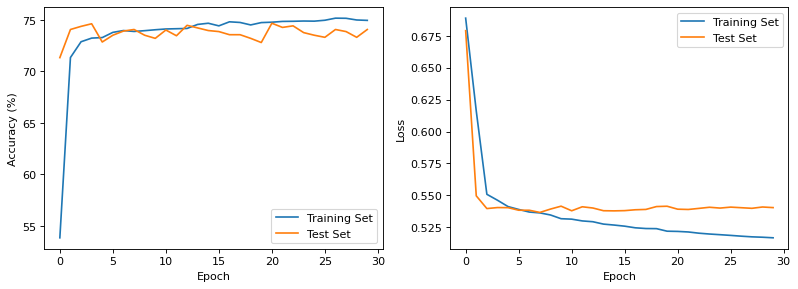

Activation Function: Softplus(beta=5, threshold=20)
Total Noise: 0.0
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.49it/s]


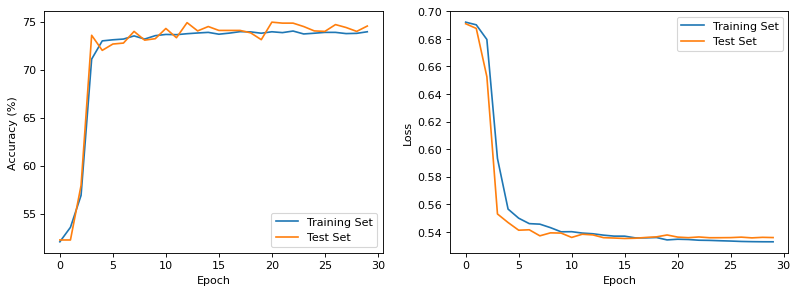

Activation Function: Softplus(beta=2, threshold=20)
Total Noise: 0.0
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.52it/s]


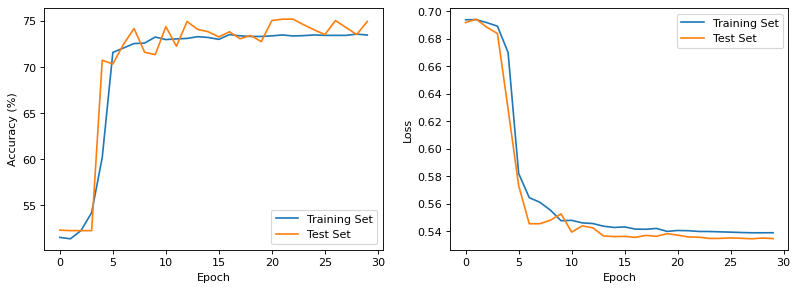

In [21]:
for i, act in enumerate(acts):
    b = str(betas[i]) if betas[i] is not None else ''
    print(f'Activation Function: {activations[i]}')
    for train_seed in train_seeds:
        base, acc_te, acc_tr, loss_te, loss_tr, pred, log, b_grads, params\
                    = train_base(weight_decay=wd, train_seed=train_seed, epochs=base_epochs,
                                 lr=lr, activation=activations[i])
        torch.save(base, output_dir+f'/base_{acts[i]+b}_wd{wd}_train_seed{train_seed}.npy')
        np.save(output_dir+f'/base_grads_{acts[i]+b}_wd{wd}_train_seed{train_seed}.npy', b_grads)
        np.save(output_dir+f'/base_loss_te_{acts[i]+b}_wd{wd}_train_seed{train_seed}.npy', loss_te)
        np.save(output_dir+f'/base_loss_tr_{acts[i]+b}_wd{wd}_train_seed{train_seed}.npy', loss_tr)

# Curvature (Retrain Models under Dataset Shift - Synthetic Noise)

In [22]:
# Standard deviations for synthetic noise
thresholds = np.logspace(-3, -0.3, 10)
thresholds

array([0.001     , 0.00199526, 0.00398107, 0.00794328, 0.01584893,
       0.03162278, 0.06309573, 0.12589254, 0.25118864, 0.50118723])

Activation: ReLU()
Threshold: 0.001
Total Noise: 0.426444659488695
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.44it/s]


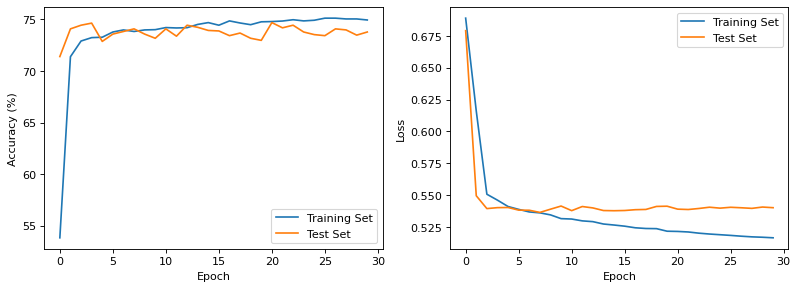

Activation: ReLU()
Threshold: 0.001995262314968879
Total Noise: 0.8508689583265279
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.23it/s]


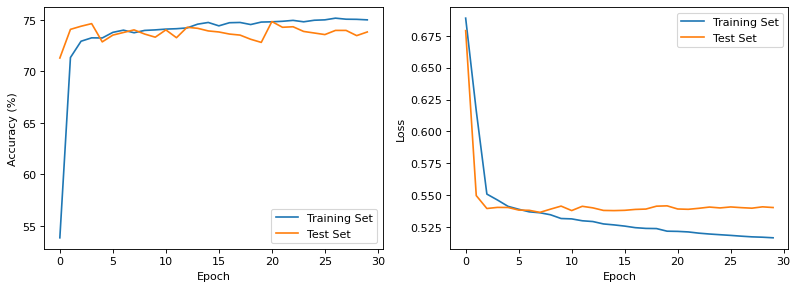

Activation: ReLU()
Threshold: 0.003981071705534973
Total Noise: 1.697706767680038
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.39it/s]


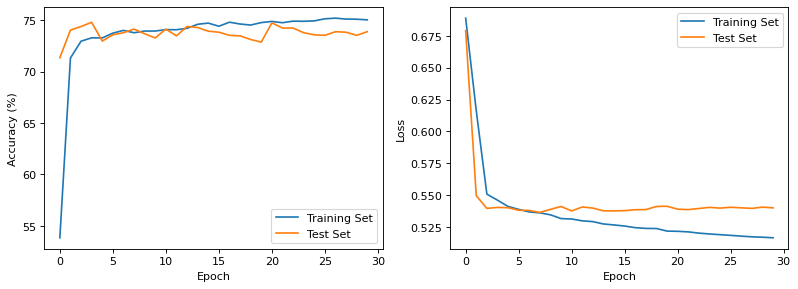

Activation: ReLU()
Threshold: 0.00794328234724282
Total Noise: 3.387370335168916
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.21it/s]


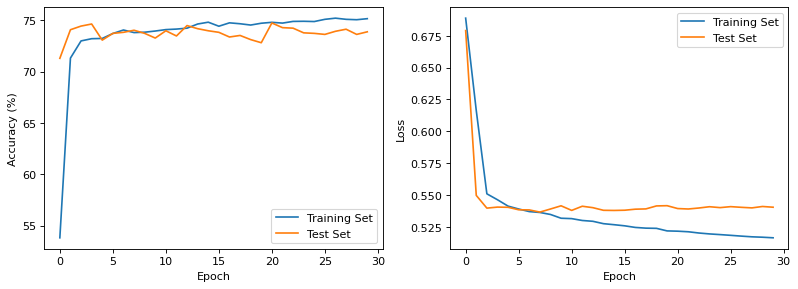

Activation: ReLU()
Threshold: 0.01584893192461114
Total Noise: 6.758692377799287
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.67it/s]


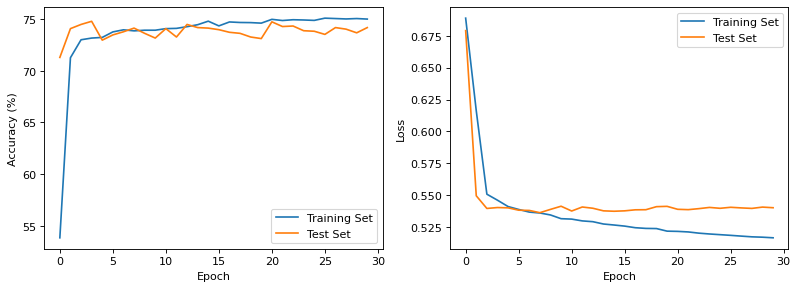

Activation: ReLU()
Threshold: 0.03162277660168381
Total Noise: 13.48536419647873
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.68it/s]


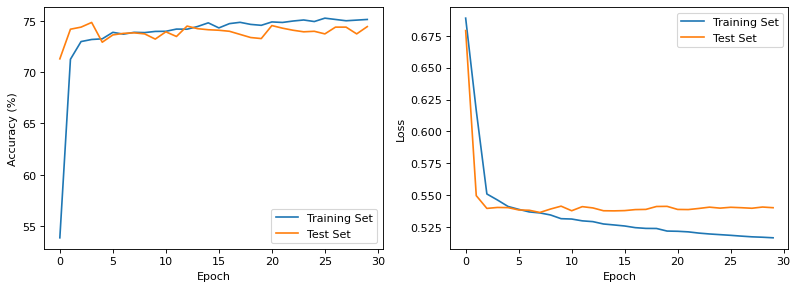

Activation: ReLU()
Threshold: 0.06309573444801936
Total Noise: 26.90683898317478
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.38it/s]


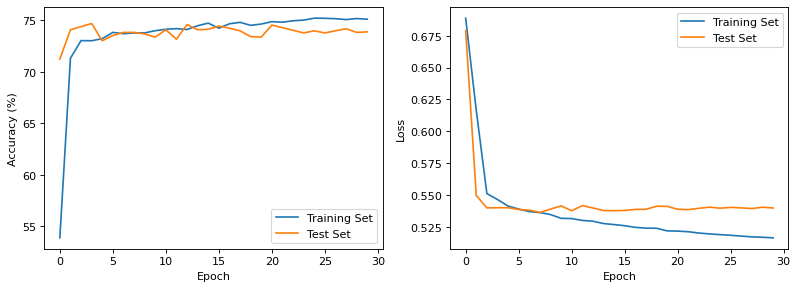

Activation: ReLU()
Threshold: 0.12589254117941687
Total Noise: 53.68620184542002
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.59it/s]


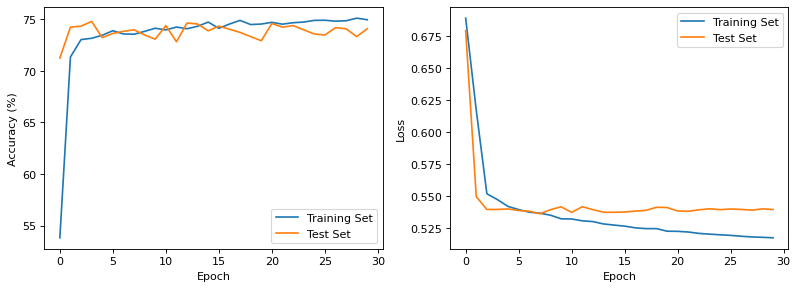

Activation: ReLU()
Threshold: 0.25118864315095824
Total Noise: 107.11805538953394
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.56it/s]


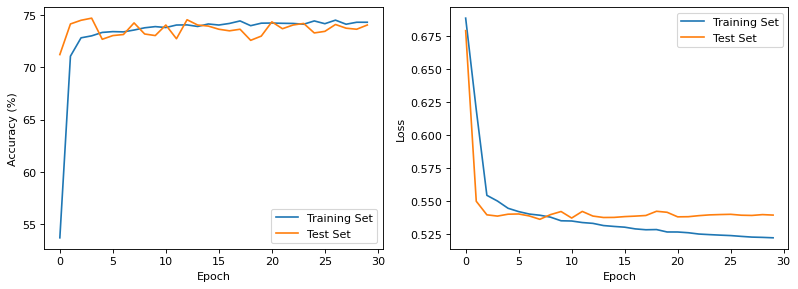

Activation: ReLU()
Threshold: 0.5011872336272722
Total Noise: 213.72861916465493
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.39it/s]


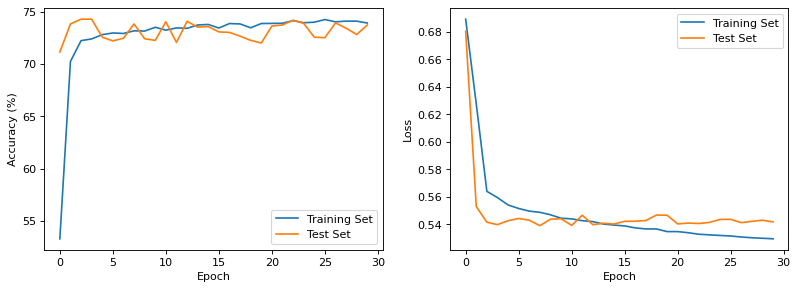

Activation: Softplus(beta=5, threshold=20)
Threshold: 0.001
Total Noise: 0.426444659488695
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.44it/s]


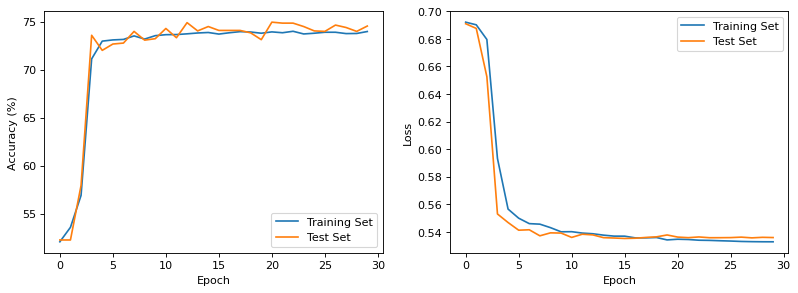

Activation: Softplus(beta=5, threshold=20)
Threshold: 0.001995262314968879
Total Noise: 0.8508689583265279
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.09it/s]


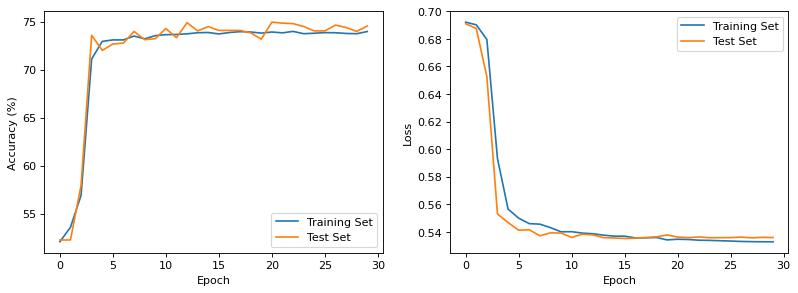

Activation: Softplus(beta=5, threshold=20)
Threshold: 0.003981071705534973
Total Noise: 1.697706767680038
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.14it/s]


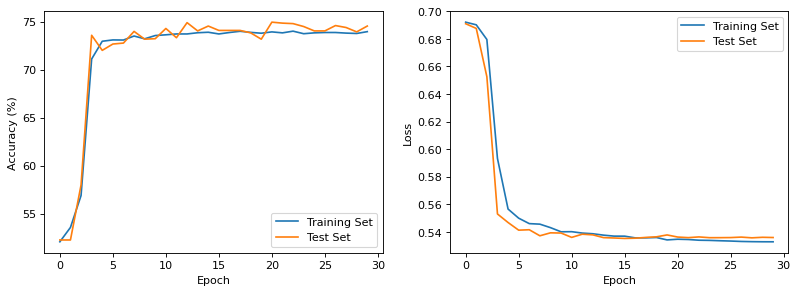

Activation: Softplus(beta=5, threshold=20)
Threshold: 0.00794328234724282
Total Noise: 3.387370335168916
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.15it/s]


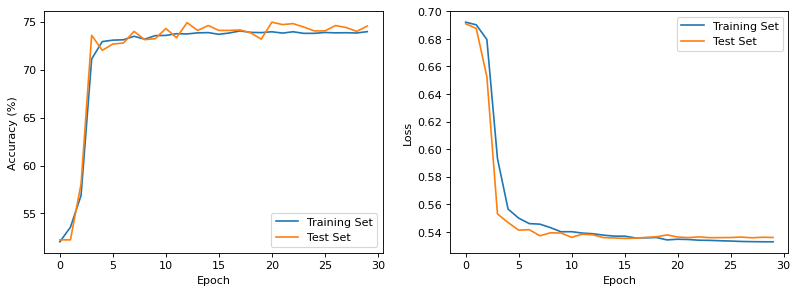

Activation: Softplus(beta=5, threshold=20)
Threshold: 0.01584893192461114
Total Noise: 6.758692377799287
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.29it/s]


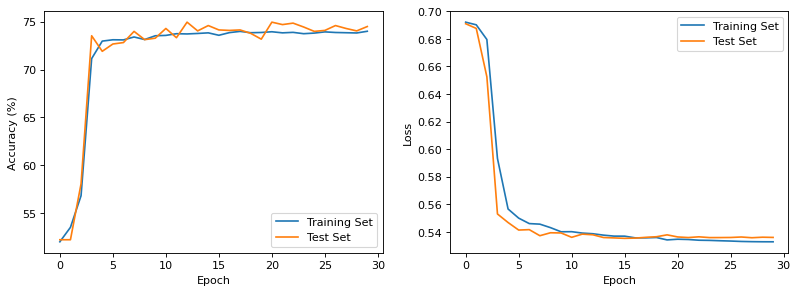

Activation: Softplus(beta=5, threshold=20)
Threshold: 0.03162277660168381
Total Noise: 13.48536419647873
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.11it/s]


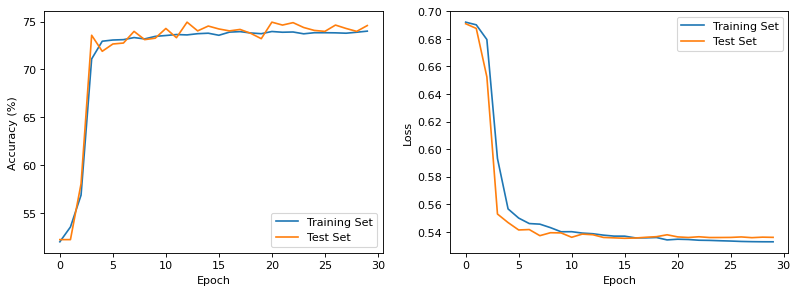

Activation: Softplus(beta=5, threshold=20)
Threshold: 0.06309573444801936
Total Noise: 26.90683898317478
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.26it/s]


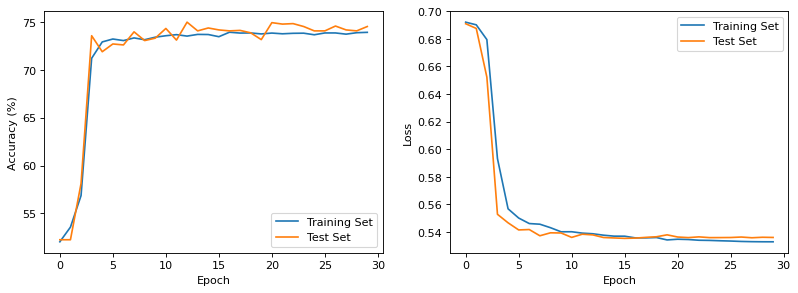

Activation: Softplus(beta=5, threshold=20)
Threshold: 0.12589254117941687
Total Noise: 53.68620184542002
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.14it/s]


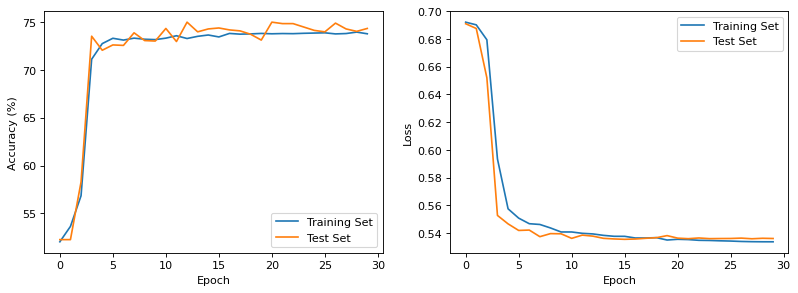

Activation: Softplus(beta=5, threshold=20)
Threshold: 0.25118864315095824
Total Noise: 107.11805538953394
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.27it/s]


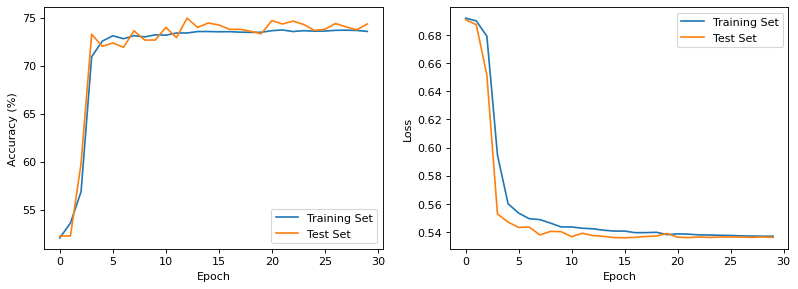

Activation: Softplus(beta=5, threshold=20)
Threshold: 0.5011872336272722
Total Noise: 213.72861916465493
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.28it/s]


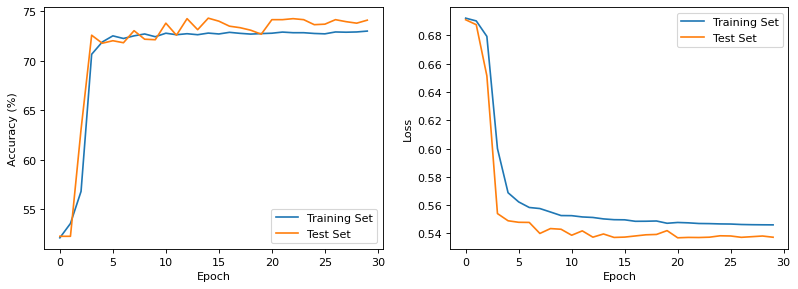

Activation: Softplus(beta=2, threshold=20)
Threshold: 0.001
Total Noise: 0.426444659488695
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.28it/s]


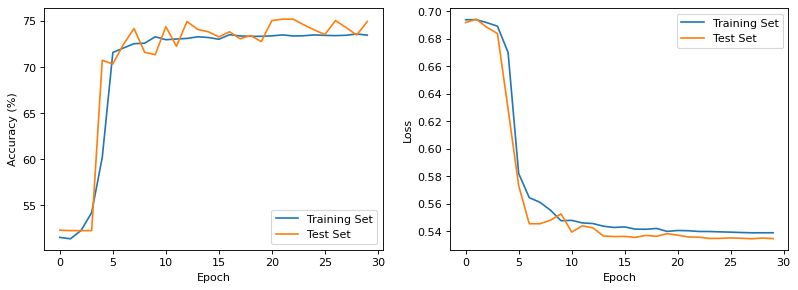

Activation: Softplus(beta=2, threshold=20)
Threshold: 0.001995262314968879
Total Noise: 0.8508689583265279
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.39it/s]


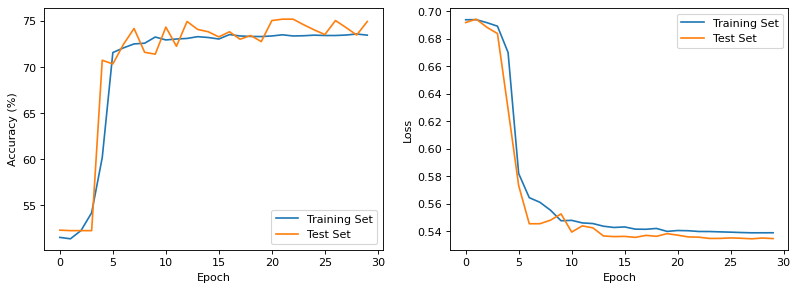

Activation: Softplus(beta=2, threshold=20)
Threshold: 0.003981071705534973
Total Noise: 1.697706767680038
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.36it/s]


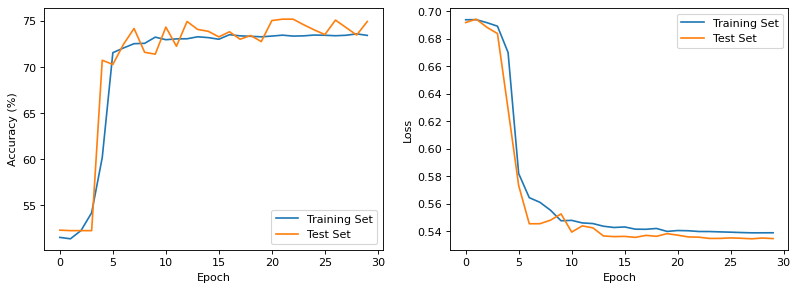

Activation: Softplus(beta=2, threshold=20)
Threshold: 0.00794328234724282
Total Noise: 3.387370335168916
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.26it/s]


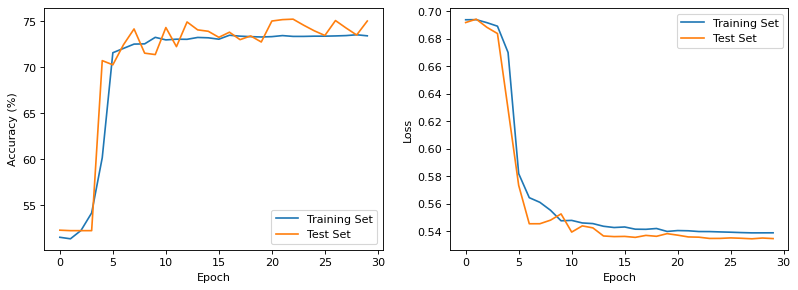

Activation: Softplus(beta=2, threshold=20)
Threshold: 0.01584893192461114
Total Noise: 6.758692377799287
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.25it/s]


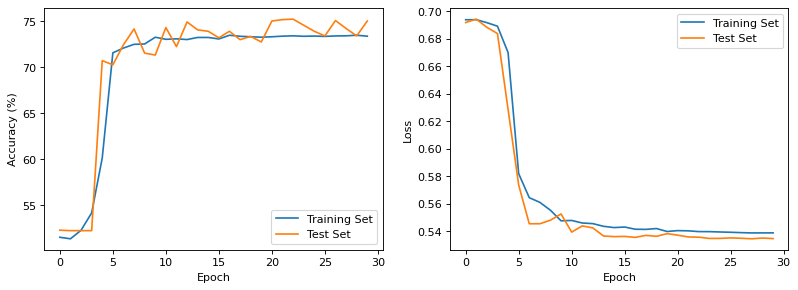

Activation: Softplus(beta=2, threshold=20)
Threshold: 0.03162277660168381
Total Noise: 13.48536419647873
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.39it/s]


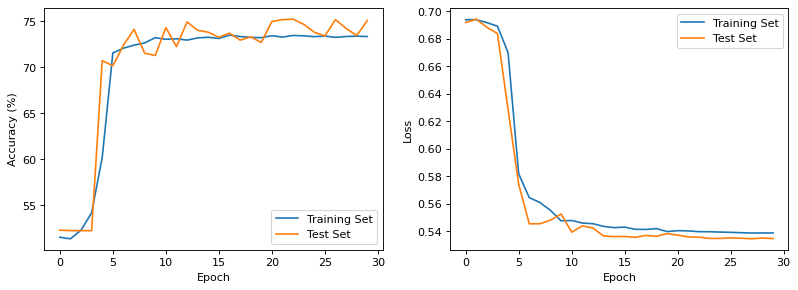

Activation: Softplus(beta=2, threshold=20)
Threshold: 0.06309573444801936
Total Noise: 26.90683898317478
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.53it/s]


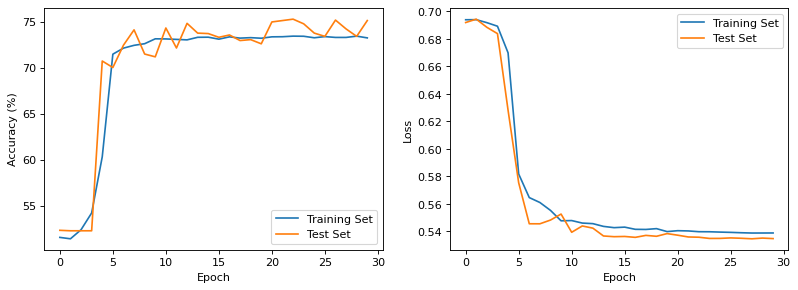

Activation: Softplus(beta=2, threshold=20)
Threshold: 0.12589254117941687
Total Noise: 53.68620184542002
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.42it/s]


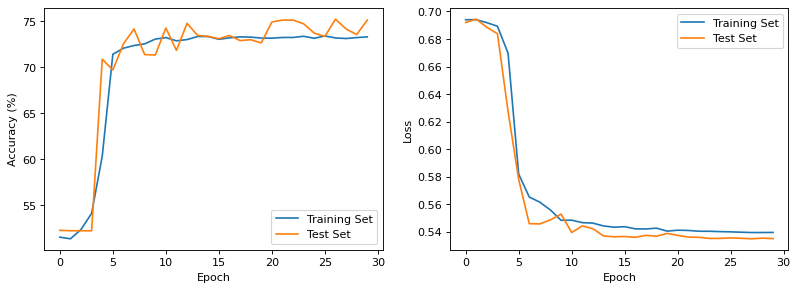

Activation: Softplus(beta=2, threshold=20)
Threshold: 0.25118864315095824
Total Noise: 107.11805538953394
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.25it/s]


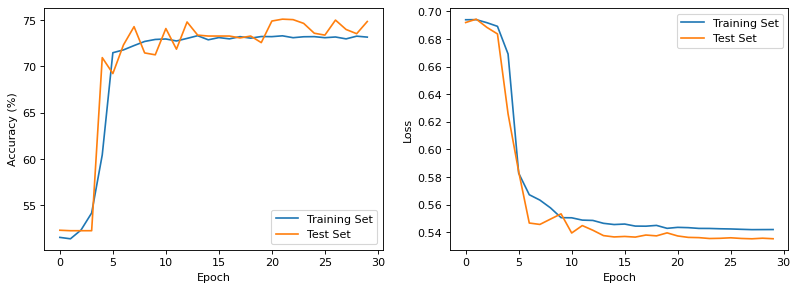

Activation: Softplus(beta=2, threshold=20)
Threshold: 0.5011872336272722
Total Noise: 213.72861916465493
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.46it/s]


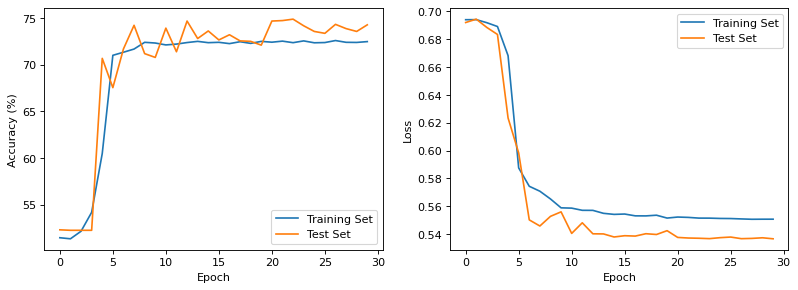

In [23]:
for t, train_seed in enumerate(train_seeds):
    for i, act in enumerate(acts):
        b = str(betas[i]) if betas[i] is not None else ''
        for j, threshold in enumerate(thresholds):
            print("Activation:", activations[i])
            print("Threshold:", threshold)
            model, acc_te2, acc_tr2, loss_te2, loss_tr2, pred2, log2, grads, params\
                    = train_base(wd, train_seed, epochs=base_epochs, lr=lr,
                                 thresh=threshold, activation=activations[i])
            torch.save(model, output_dir+f'/model_thresh_idx{j}_{acts[i]+b}_wd{wd}_train_seed{train_seed}.npy')

# Curvature (Compute Gradients and Explanations)

In [32]:
from neural_net import eval_model_grad
from torch.utils.data import DataLoader
test_dataloader = DataLoader(orig_test, batch_size=args.batch_size, shuffle=False)

In [54]:
wd = 0.001
train_seeds, acts, wd

([3], ['relu', 'soft', 'soft'], 0.001)

In [55]:
weight_change = np.zeros((len(acts), len(train_seeds), len(thresholds)))
grad_change = np.zeros((len(acts), len(train_seeds), len(thresholds), n_te))
for t, train_seed in enumerate(train_seeds):
    for i, act in enumerate(acts):
        print(f'Train Seed: {train_seed}\nActivation: {activations[i]}')
        b = str(betas[i]) if betas[i] is not None else ''
        base = torch.load(output_dir+f'/base_{acts[i]+b}_wd{wd}_train_seed{train_seed}.npy')
        
        # Compute gradients, salience, smoothgrad, lime, shap
        _, _, grads, salience, smoothgrad, lime_grads, kernel_shap\
        = eval_model_grad(test_dataloader, base, '', 0, test_lime=True,
                          total_lime_samples=100, n_samples=500)
        
        # Assert gradients == b_grads
        b_grads = np.load(output_dir+f'/base_grads_{acts[i]+b}_wd{wd}_train_seed{train_seed}.npy')
        if not (np.array(grads)==b_grads).all():
            print(f'Gradients do not match at train seed {train_seed} and activation {activations[i]}')
        
        # Save gradients/explanations
        np.save(output_dir+f'/base_salience_{acts[i]+b}_wd{wd}_train_seed{train_seed}.npy', salience)
        np.save(output_dir+f'/base_smoothgrad_{acts[i]+b}_wd{wd}_train_seed{train_seed}.npy', smoothgrad)
        np.save(output_dir+f'/base_lime_grads_{acts[i]+b}_wd{wd}_train_seed{train_seed}.npy', lime_grads)
        np.save(output_dir+f'/base_kernel_shap_{acts[i]+b}_wd{wd}_train_seed{train_seed}.npy', kernel_shap)
        
        for j, threshold in enumerate(tqdm(thresholds)):
            model = torch.load(output_dir+f'/model_thresh_idx{j}_{acts[i]+b}_wd{wd}_train_seed{train_seed}.npy')
            # Compute gradients, salience, smoothgrad, lime, shap
            _, _, grads, salience, smoothgrad, lime_grads, kernel_shap\
            = eval_model_grad(test_dataloader, model, '', 0, test_lime=True,
                              total_lime_samples=100, n_samples=500)
            np.save(output_dir+f'/model_thresh_idx{j}_salience_{acts[i]+b}_wd{wd}_train_seed{train_seed}.npy', salience)
            np.save(output_dir+f'/model_thresh_idx{j}_smoothgrad_{acts[i]+b}_wd{wd}_train_seed{train_seed}.npy', smoothgrad)
            np.save(output_dir+f'/model_thresh_idx{j}_lime_grads_{acts[i]+b}_wd{wd}_train_seed{train_seed}.npy', lime_grads)
            np.save(output_dir+f'/model_thresh_idx{j}_kernel_shap_{acts[i]+b}_wd{wd}_train_seed{train_seed}.npy', kernel_shap)         
            weight_change[i,t,j] = compute_weight_change(base, model)
            grad_change[i,t,j] = np.linalg.norm(b_grads-np.array(grads), axis=1)
np.save(output_dir+'/weight_change_curvature.npy', weight_change)
np.save(output_dir+'/grad_change_curvature.npy', grad_change)

Train Seed: 3
Activation: ReLU()


100%|███████████████████████████████████████████| 10/10 [02:28<00:00, 14.86s/it]


Train Seed: 3
Activation: Softplus(beta=5, threshold=20)


100%|███████████████████████████████████████████| 10/10 [02:32<00:00, 15.21s/it]


Train Seed: 3
Activation: Softplus(beta=2, threshold=20)


100%|███████████████████████████████████████████| 10/10 [02:31<00:00, 15.15s/it]


# Curvature (Compute Top-K Explanation Stability)

In [56]:
from metrics import get_top_k, top_k_sa, top_k_cdc, top_k_ssa

In [57]:
exps = ['salience', 'smoothgrad', 'lime_grads', 'kernel_shap']
mets = [top_k_sa, top_k_cdc, top_k_ssa] #
met_names = ['sa', 'cdc', 'ssa']
ks = [5]  # values of k in top-k

In [58]:
for exp in exps:
    print(f'Computing {exp.title()} Metrics...')
    for m, met in enumerate(tqdm(mets)):
        for k in ks:
            exp_met_ks = np.zeros((len(acts), len(train_seeds), len(thresholds)))
            for i, act in enumerate(acts):
                for t, train_seed in enumerate(train_seeds):
                    b = str(betas[i]) if betas[i] is not None else ''
                    # g1 represents base model gradients
                    g1 = np.load(output_dir+f'/base_{exp}_{acts[i]+b}_wd{wd}_train_seed{train_seed}.npy')
                    s1 = np.sign(g1)
                    tk1 = get_top_k(k, g1)

                    for j, threshold in enumerate(thresholds):
                        # g2 represents shifted model gradients
                        g2 = np.load(output_dir+f'/model_thresh_idx{j}_{exp}_{acts[i]+b}_wd{wd}_train_seed{train_seed}.npy')
                        s2 = np.sign(g2)
                        tk2 = get_top_k(k, g2)
                        exp_met_ks[i,t,j] = met(k, tk1, tk2, s1, s2)
            # save exp-met-k combo
            np.save(output_dir+f'/{exp}_top_{k}_{met_names[m]}.npy', exp_met_ks)

Computing Salience Metrics...


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.08it/s]


Computing Smoothgrad Metrics...


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.16it/s]


Computing Lime_Grads Metrics...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 33.09it/s]


Computing Kernel_Shap Metrics...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 32.77it/s]


# Weight Decay (Train Base Models)

In [40]:
wds = [0, 0.005, 0.01]  # can omit 0.001 here as it already exists from above
act = 'relu'
activation = nn.ReLU()

In [41]:
base_epochs = 30
lr = 0.2

In [42]:
train_seeds

[3]

Weight Decay = 0
Total Noise: 0.0
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.58it/s]


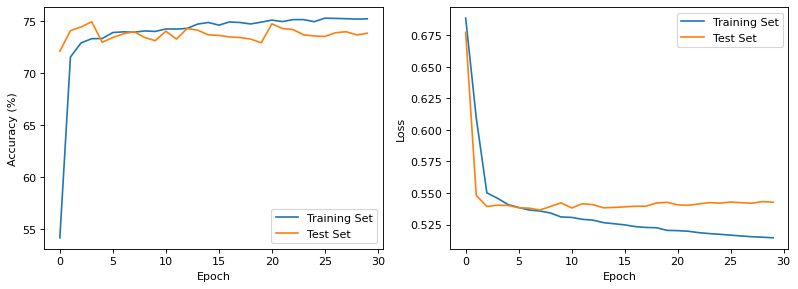

Weight Decay = 0.005
Total Noise: 0.0
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.55it/s]


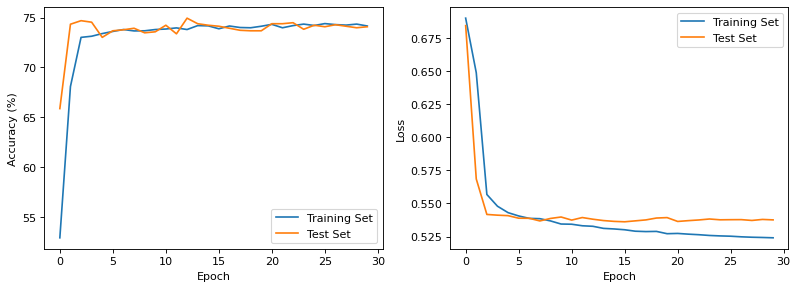

Weight Decay = 0.01
Total Noise: 0.0
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.16it/s]


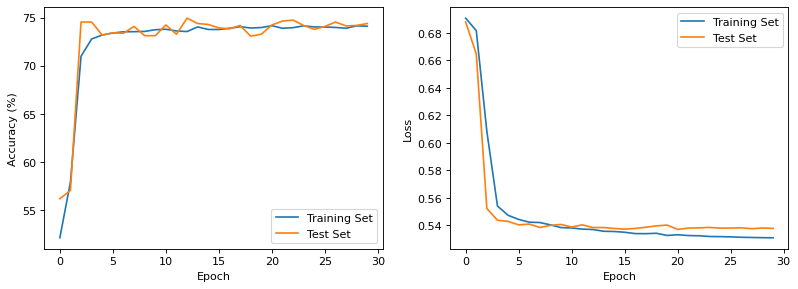

In [44]:
for train_seed in train_seeds:
    for i, wd in enumerate(wds):
        print(f'Weight Decay = {wd}')
        base, acc_te, acc_tr, loss_te, loss_tr, pred, log, b_grads, params\
                    = train_base(weight_decay=wd, train_seed=train_seed, epochs=base_epochs,
                                 lr=lr, activation=activation)
        torch.save(base, output_dir+f'/base_{act}_wd{wd}_train_seed{train_seed}.npy')
        np.save(output_dir+f'/base_grads_{act}_wd{wd}_train_seed{train_seed}.npy', b_grads)
        np.save(output_dir+f'/base_loss_te_{act}_wd{wd}_train_seed{train_seed}.npy', loss_te)
        np.save(output_dir+f'/base_loss_tr_{act}_wd{wd}_train_seed{train_seed}.npy', loss_tr)

# Weight Decay (Retrain Models under Dataset Shift - Synthetic Noise)

In [45]:
# Standard deviations for synthetic noise
thresholds = np.logspace(-3, -0.3, 10)
thresholds

array([0.001     , 0.00199526, 0.00398107, 0.00794328, 0.01584893,
       0.03162278, 0.06309573, 0.12589254, 0.25118864, 0.50118723])

Weight Decay: 0
Threshold: 0.001
Total Noise: 0.426444659488695
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.59it/s]


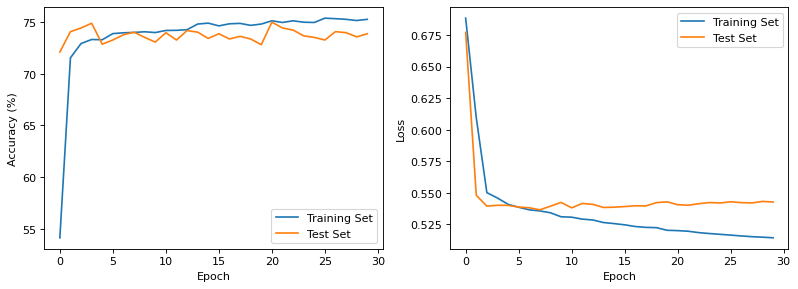

Weight Decay: 0
Threshold: 0.001995262314968879
Total Noise: 0.8508689583265279
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.63it/s]


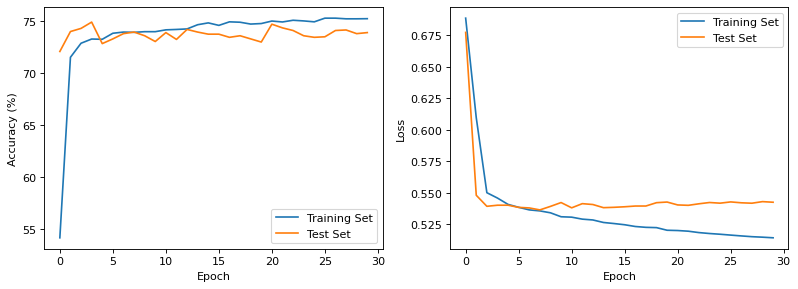

Weight Decay: 0
Threshold: 0.003981071705534973
Total Noise: 1.697706767680038
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.42it/s]


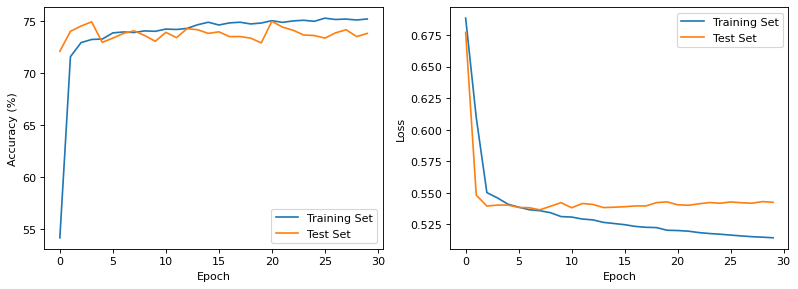

Weight Decay: 0
Threshold: 0.00794328234724282
Total Noise: 3.387370335168916
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.68it/s]


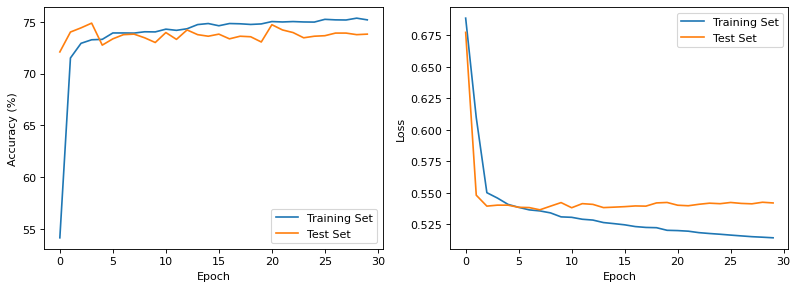

Weight Decay: 0
Threshold: 0.01584893192461114
Total Noise: 6.758692377799287
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.67it/s]


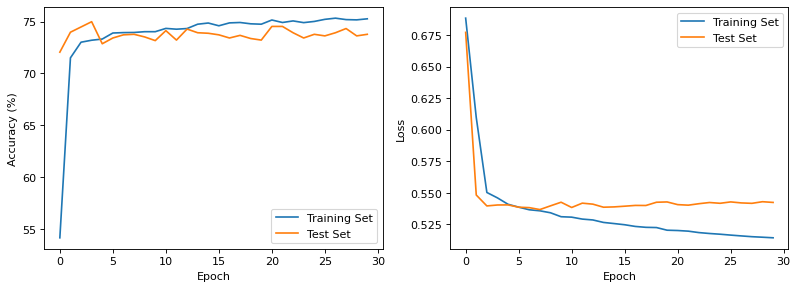

Weight Decay: 0
Threshold: 0.03162277660168381
Total Noise: 13.48536419647873
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.30it/s]


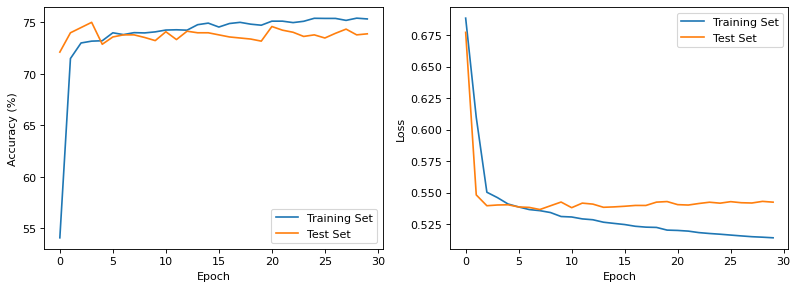

Weight Decay: 0
Threshold: 0.06309573444801936
Total Noise: 26.90683898317478
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.32it/s]


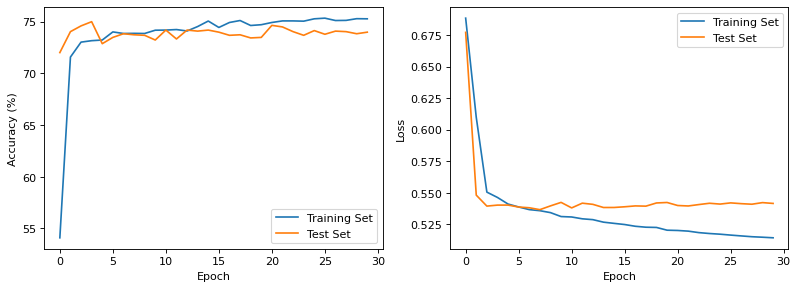

Weight Decay: 0
Threshold: 0.12589254117941687
Total Noise: 53.68620184542002
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.25it/s]


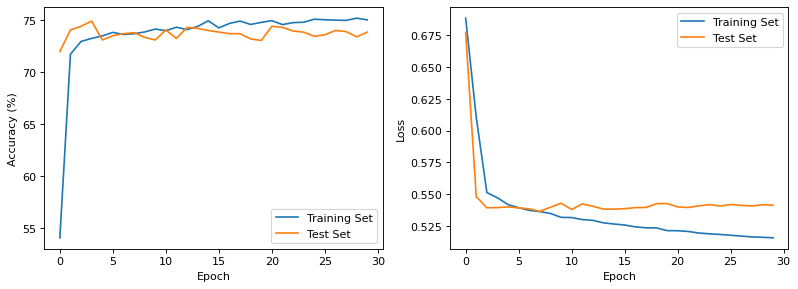

Weight Decay: 0
Threshold: 0.25118864315095824
Total Noise: 107.11805538953394
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.20it/s]


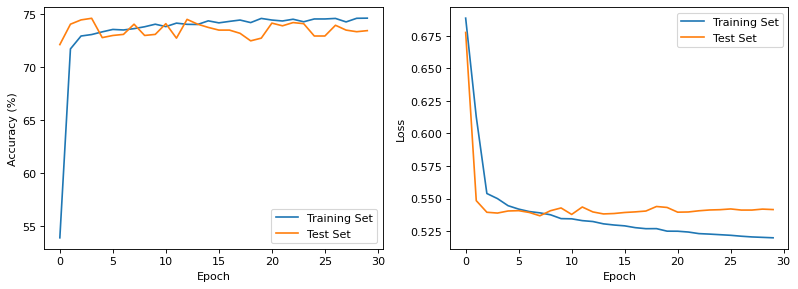

Weight Decay: 0
Threshold: 0.5011872336272722
Total Noise: 213.72861916465493
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.26it/s]


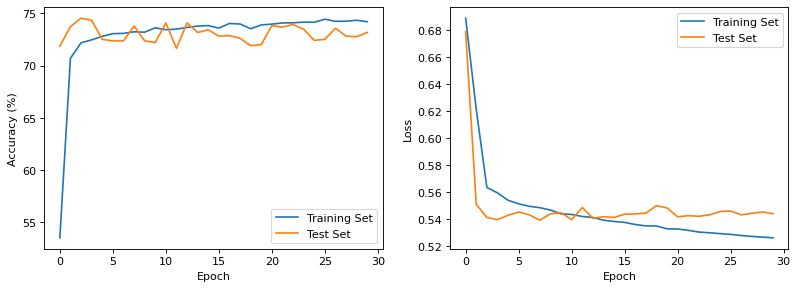

Weight Decay: 0.005
Threshold: 0.001
Total Noise: 0.426444659488695
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.29it/s]


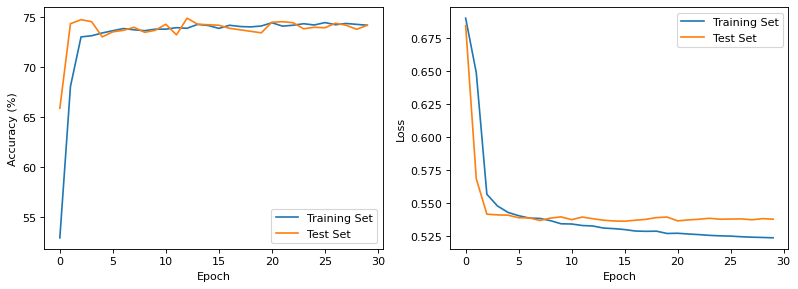

Weight Decay: 0.005
Threshold: 0.001995262314968879
Total Noise: 0.8508689583265279
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.26it/s]


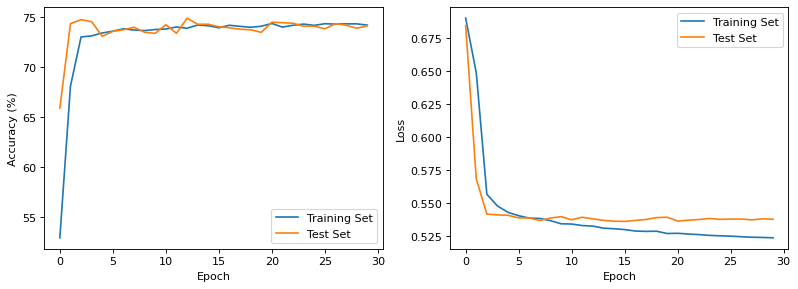

Weight Decay: 0.005
Threshold: 0.003981071705534973
Total Noise: 1.697706767680038
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.18it/s]


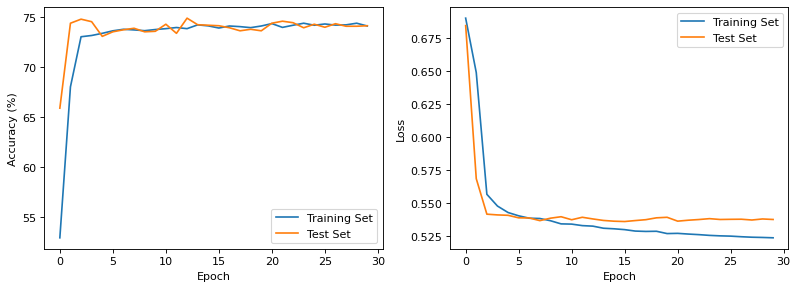

Weight Decay: 0.005
Threshold: 0.00794328234724282
Total Noise: 3.387370335168916
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.45it/s]


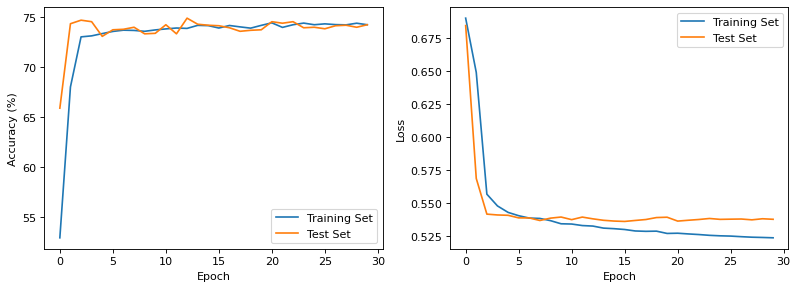

Weight Decay: 0.005
Threshold: 0.01584893192461114
Total Noise: 6.758692377799287
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.26it/s]


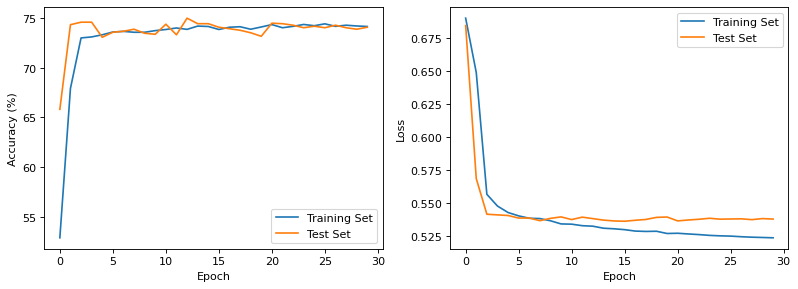

Weight Decay: 0.005
Threshold: 0.03162277660168381
Total Noise: 13.48536419647873
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.66it/s]


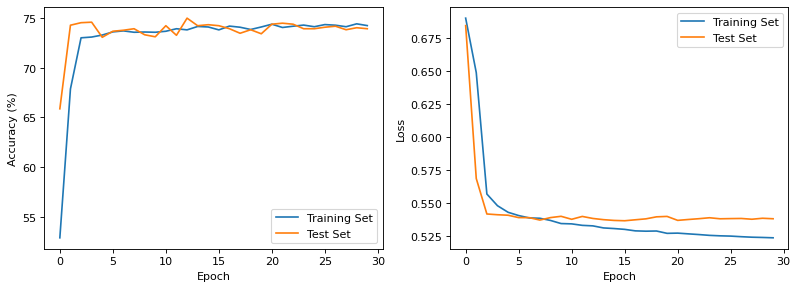

Weight Decay: 0.005
Threshold: 0.06309573444801936
Total Noise: 26.90683898317478
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.65it/s]


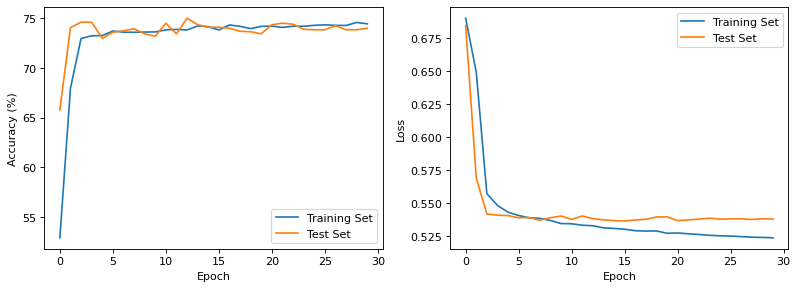

Weight Decay: 0.005
Threshold: 0.12589254117941687
Total Noise: 53.68620184542002
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.60it/s]


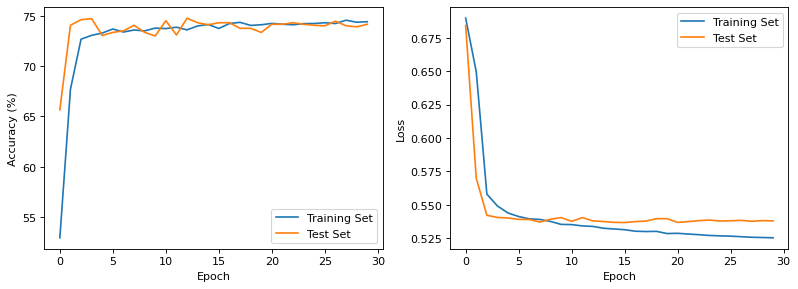

Weight Decay: 0.005
Threshold: 0.25118864315095824
Total Noise: 107.11805538953394
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.47it/s]


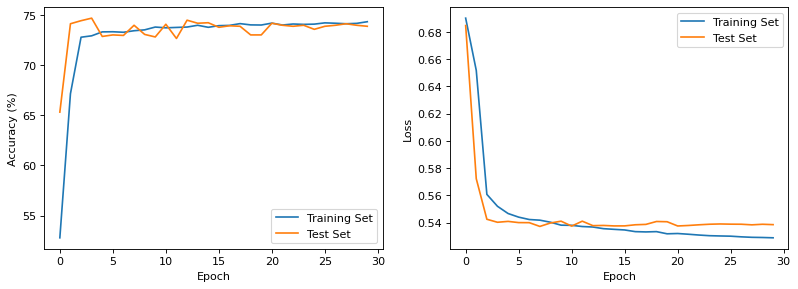

Weight Decay: 0.005
Threshold: 0.5011872336272722
Total Noise: 213.72861916465493
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.58it/s]


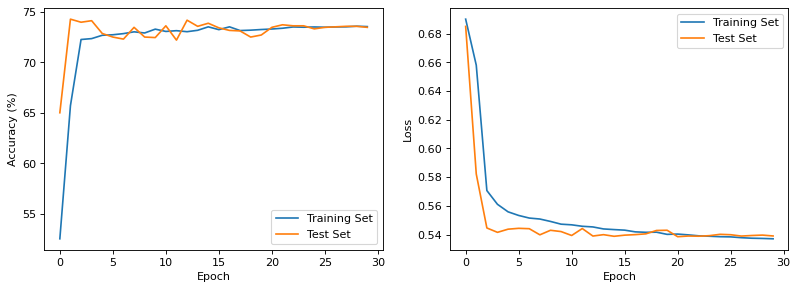

Weight Decay: 0.01
Threshold: 0.001
Total Noise: 0.426444659488695
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.63it/s]


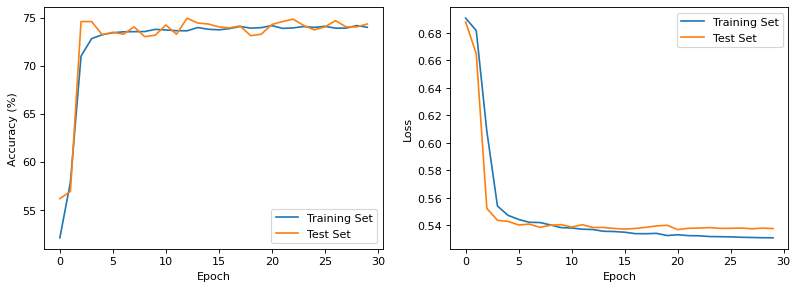

Weight Decay: 0.01
Threshold: 0.001995262314968879
Total Noise: 0.8508689583265279
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.67it/s]


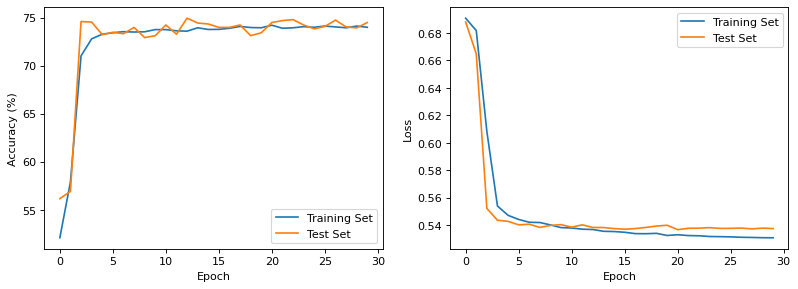

Weight Decay: 0.01
Threshold: 0.003981071705534973
Total Noise: 1.697706767680038
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.56it/s]


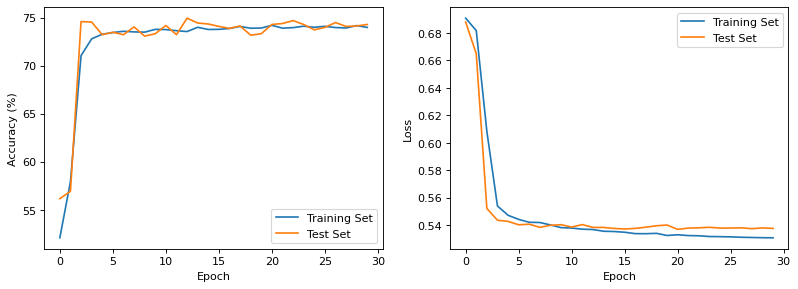

Weight Decay: 0.01
Threshold: 0.00794328234724282
Total Noise: 3.387370335168916
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.16it/s]


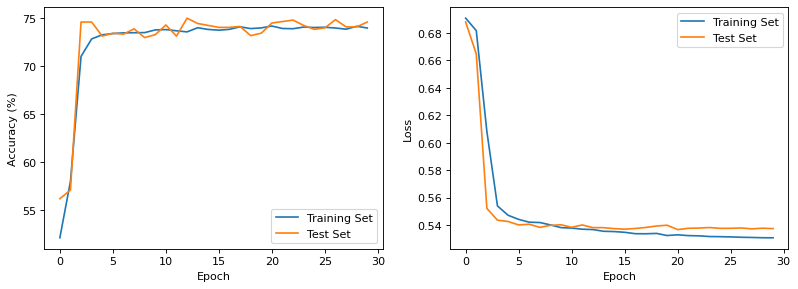

Weight Decay: 0.01
Threshold: 0.01584893192461114
Total Noise: 6.758692377799287
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.30it/s]


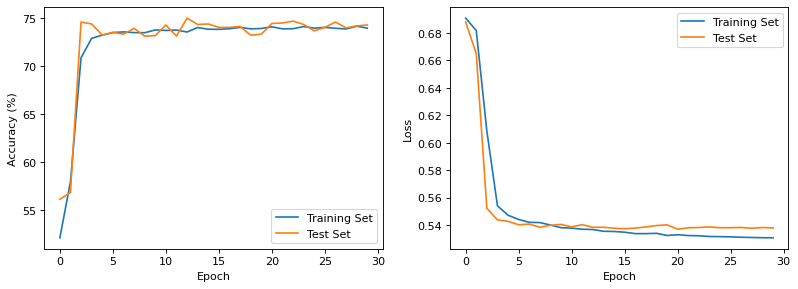

Weight Decay: 0.01
Threshold: 0.03162277660168381
Total Noise: 13.48536419647873
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.23it/s]


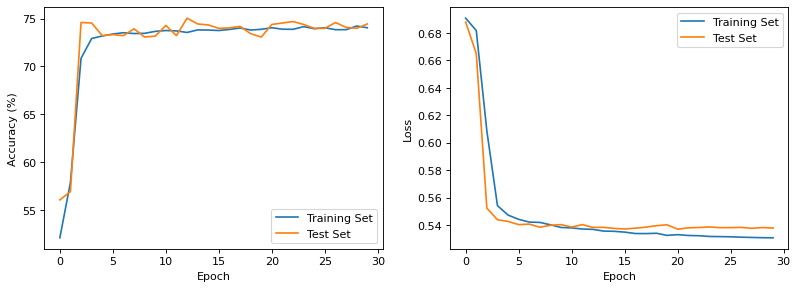

Weight Decay: 0.01
Threshold: 0.06309573444801936
Total Noise: 26.90683898317478
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.28it/s]


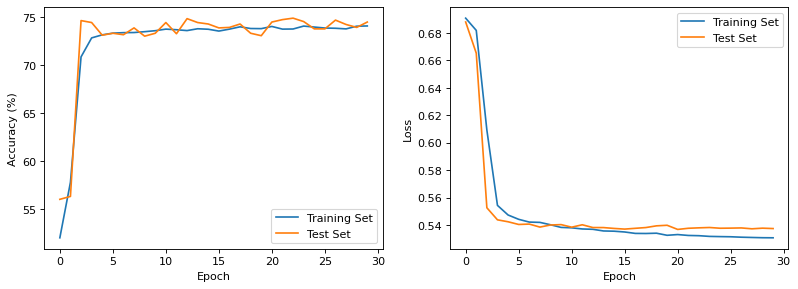

Weight Decay: 0.01
Threshold: 0.12589254117941687
Total Noise: 53.68620184542002
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.58it/s]


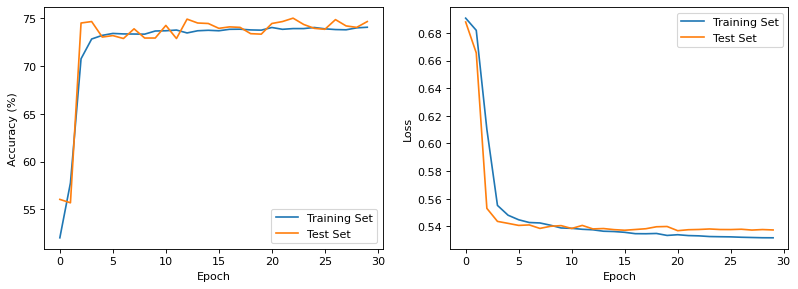

Weight Decay: 0.01
Threshold: 0.25118864315095824
Total Noise: 107.11805538953394
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.57it/s]


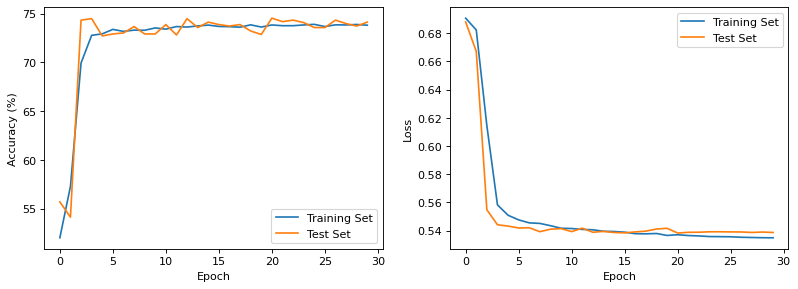

Weight Decay: 0.01
Threshold: 0.5011872336272722
Total Noise: 213.72861916465493
Training with Seed 3


100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.57it/s]


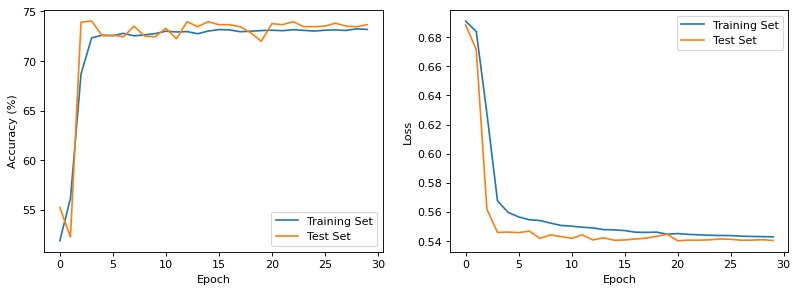

In [46]:
for t, train_seed in enumerate(train_seeds):
    for i, wd in enumerate(wds):
        for j, threshold in enumerate(thresholds):
            print("Weight Decay:", wd)
            print("Threshold:", threshold)
            model, acc_te2, acc_tr2, loss_te2, loss_tr2, pred2, log2, grads, params\
                    = train_base(wd, train_seed, epochs=base_epochs, lr=lr,
                                 thresh=threshold, activation=activation)
            torch.save(model, output_dir+f'/model_thresh_idx{j}_{act}_wd{wd}_train_seed{train_seed}.npy')

# Weight Decay (Compute Gradients and Explanations)

In [47]:
from torch.utils.data import DataLoader
from neural_net import eval_model_grad
test_dataloader = DataLoader(orig_test, batch_size=params.batch_size, shuffle=False)

In [48]:
train_seeds

[3]

In [69]:
wds = [0, 0.001, 0.005, 0.01]
act = 'relu'
activation = nn.ReLU()

In [70]:
weight_change = np.zeros((len(wds), len(train_seeds), len(thresholds)))
grad_change = np.zeros((len(wds), len(train_seeds), len(thresholds), n_te))
for t, train_seed in enumerate(train_seeds):
    for i, wd in enumerate(wds):
        print(f'Train Seed: {train_seed}\nWeight Decay: {wd}')
        base = torch.load(output_dir+f'/base_{act}_wd{wd}_train_seed{train_seed}.npy')
        
        # Compute gradients, salience, smoothgrad, lime, shap
        _, _, grads, salience, smoothgrad, lime_grads, kernel_shap\
        = eval_model_grad(test_dataloader, base, '', 0, test_lime=True,
                          total_lime_samples=100, n_samples=500)
        
        # Assert gradients == b_grads
        b_grads = np.load(output_dir+f'/base_grads_{act}_wd{wd}_train_seed{train_seed}.npy')
        if not (np.array(grads)==b_grads).all():
            print(f'Gradients do not match at train seed {train_seed} and weight decay {wd}')
        
        # Save gradients/explanations
        np.save(output_dir+f'/base_salience_{act}_wd{wd}_train_seed{train_seed}.npy', salience)
        np.save(output_dir+f'/base_smoothgrad_{act}_wd{wd}_train_seed{train_seed}.npy', smoothgrad)
        np.save(output_dir+f'/base_lime_grads_{act}_wd{wd}_train_seed{train_seed}.npy', lime_grads)
        np.save(output_dir+f'/base_kernel_shap_{act}_wd{wd}_train_seed{train_seed}.npy', kernel_shap)
        
        for j, threshold in enumerate(tqdm(thresholds)):
            model = torch.load(output_dir+f'/model_thresh_idx{j}_{act}_wd{wd}_train_seed{train_seed}.npy')
            # Compute gradients, salience, smoothgrad, lime, shap
            _, _, grads, salience, smoothgrad, lime_grads, kernel_shap\
            = eval_model_grad(test_dataloader, model, '', 0, test_lime=True,
                              total_lime_samples=100, n_samples=500)
            np.save(output_dir+f'/model_thresh_idx{j}_salience_{act}_wd{wd}_train_seed{train_seed}.npy', salience)
            np.save(output_dir+f'/model_thresh_idx{j}_smoothgrad_{act}_wd{wd}_train_seed{train_seed}.npy', smoothgrad)
            np.save(output_dir+f'/model_thresh_idx{j}_lime_grads_{act}_wd{wd}_train_seed{train_seed}.npy', lime_grads)
            np.save(output_dir+f'/model_thresh_idx{j}_kernel_shap_{act}_wd{wd}_train_seed{train_seed}.npy', kernel_shap)         
            weight_change[i,t,j] = compute_weight_change(base, model)
            grad_change[i,t,j] = np.linalg.norm(b_grads-np.array(grads), axis=1)
np.save(output_dir+'/weight_change_wd.npy', weight_change)
np.save(output_dir+'/grad_change_wd.npy', grad_change)

Train Seed: 3
Weight Decay: 0


100%|███████████████████████████████████████████| 10/10 [02:28<00:00, 14.84s/it]


Train Seed: 3
Weight Decay: 0.001


100%|███████████████████████████████████████████| 10/10 [02:30<00:00, 15.06s/it]


Train Seed: 3
Weight Decay: 0.005


100%|███████████████████████████████████████████| 10/10 [02:30<00:00, 15.07s/it]


Train Seed: 3
Weight Decay: 0.01


100%|███████████████████████████████████████████| 10/10 [02:31<00:00, 15.14s/it]


# Weight Decays (Compute Top-K Explanation Stability)

In [100]:
from metrics import get_top_k, top_k_sa, top_k_cdc, top_k_ssa

In [101]:
exps = ['salience', 'smoothgrad', 'lime_grads', 'kernel_shap']
mets = [top_k_sa, top_k_cdc, top_k_ssa]
met_names = ['sa', 'cdc', 'ssa']
ks = [5]

In [102]:
act = 'relu'
wds

[0, 0.001, 0.005, 0.01]

In [103]:
for exp in exps:
    print(f'Computing {exp.title()} Metrics...')
    for m, met in enumerate(tqdm(mets)):
        for k in ks:
            exp_met_ks = np.zeros((len(wds), len(train_seeds), len(thresholds)))
            for i, wd in enumerate(wds):
                for t, train_seed in enumerate(train_seeds):
                    # g1 represents base model explanations
                    g1 = np.load(output_dir+f'/base_{exp}_{act}_wd{wd}_train_seed{train_seed}.npy')
                    s1 = np.sign(g1)
                    tk1 = get_top_k(k, g1)

                    for j, threshold in enumerate(thresholds):
                        # g2 represents shifted model explanations
                        g2 = np.load(output_dir+f'/model_thresh_idx{j}_{exp}_{act}_wd{wd}_train_seed{train_seed}.npy')
                        s2 = np.sign(g2)
                        tk2 = get_top_k(k, g2)
                        exp_met_ks[i,t,j] = met(k, tk1, tk2, s1, s2)
            # save exp-met-k combo
            np.save(output_dir+f'/{exp}_top_{k}_{met_names[m]}_wd.npy', exp_met_ks)

Computing Salience Metrics...


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.55it/s]


Computing Smoothgrad Metrics...


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.60it/s]


Computing Lime_Grads Metrics...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 25.75it/s]


Computing Kernel_Shap Metrics...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 25.51it/s]


# Plot Parameter/Gradient Stability

In [85]:
from plots import weight_grad_plot, top_k_plot

### Effect of Curvature

In [81]:
weight_change_curvature = np.load(output_dir+'/weight_change_curvature.npy')
grad_change_curvature = np.load(output_dir+'/grad_change_curvature.npy')
labs = ['Relu', 'Softplus (β=5)', f'Softplus (β=2)']

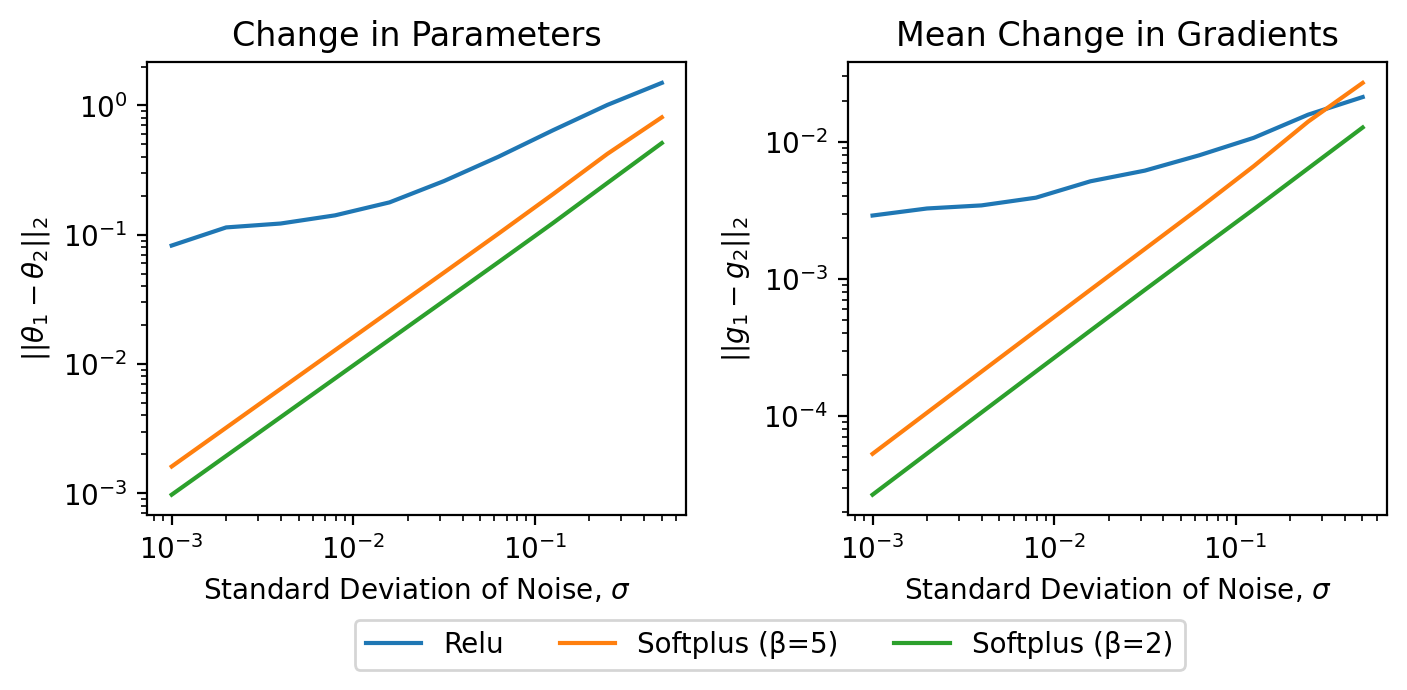

In [82]:
weight_grad_plot(thresholds, weight_change_curvature, grad_change_curvature, labs, qs=[0.25, 0.5, 0.75])

### Effect of Weight Decay

In [79]:
weight_change_wd = np.load(output_dir+'/weight_change_wd.npy')
grad_change_wd = np.load(output_dir+'/grad_change_wd.npy')
wds = [0, 0.001, 0.005, 0.01]
labs = [f'$\gamma={wd}$' for wd in wds]

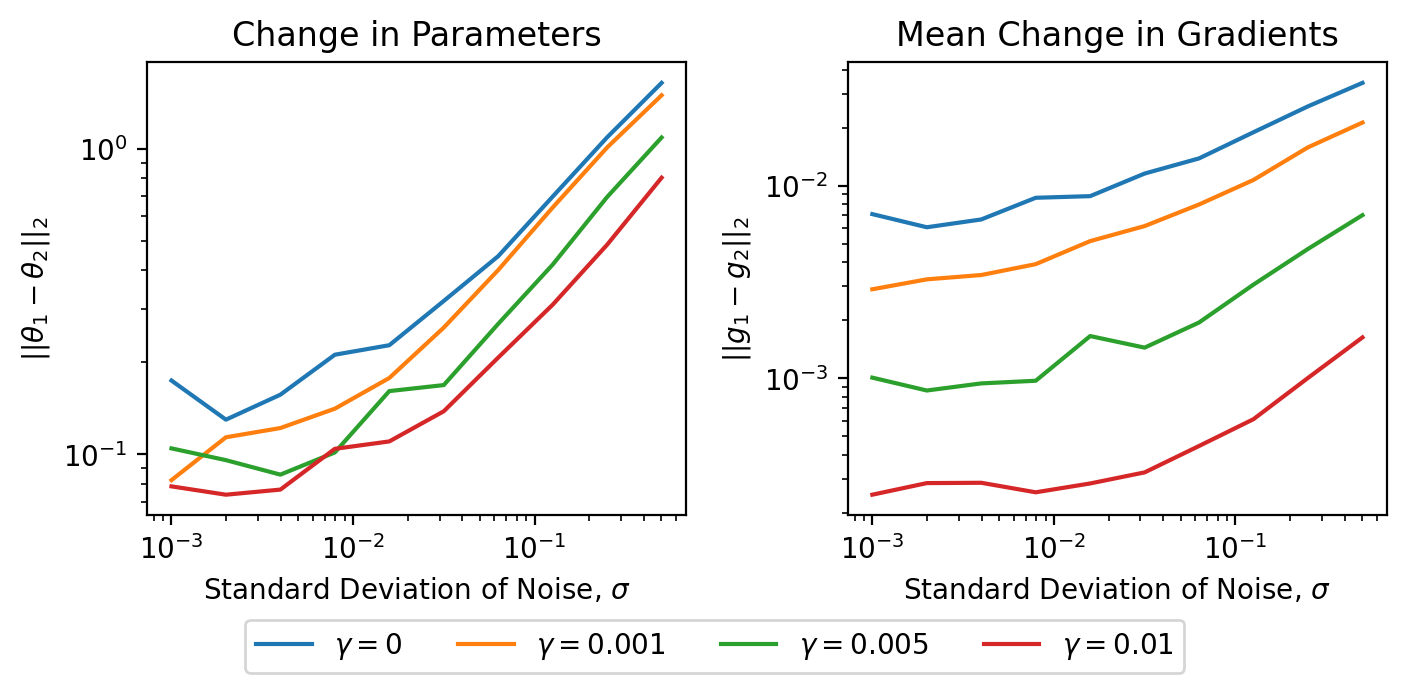

In [80]:
weight_grad_plot(thresholds, weight_change_wd, grad_change_wd, labs, qs=[0.25, 0.5, 0.75])

# Plot Explanation Stability

In [113]:
wds = [0, 0.001, 0.005, 0.01]
labs_wd = [f'$\gamma={wd}$' for wd in wds]
labs_curvature = ['ReLU', r'Softplus (β=5)', r'Softplus (β=2)']
labs = [labs_wd, labs_curvature]
met_names = ['sa', 'cdc', 'ssa']
k=5

### Saliency/SmoothGrad

In [114]:
exps = ['salience', 'smoothgrad']
exp_names = ['Saliency', 'SmoothGrad']

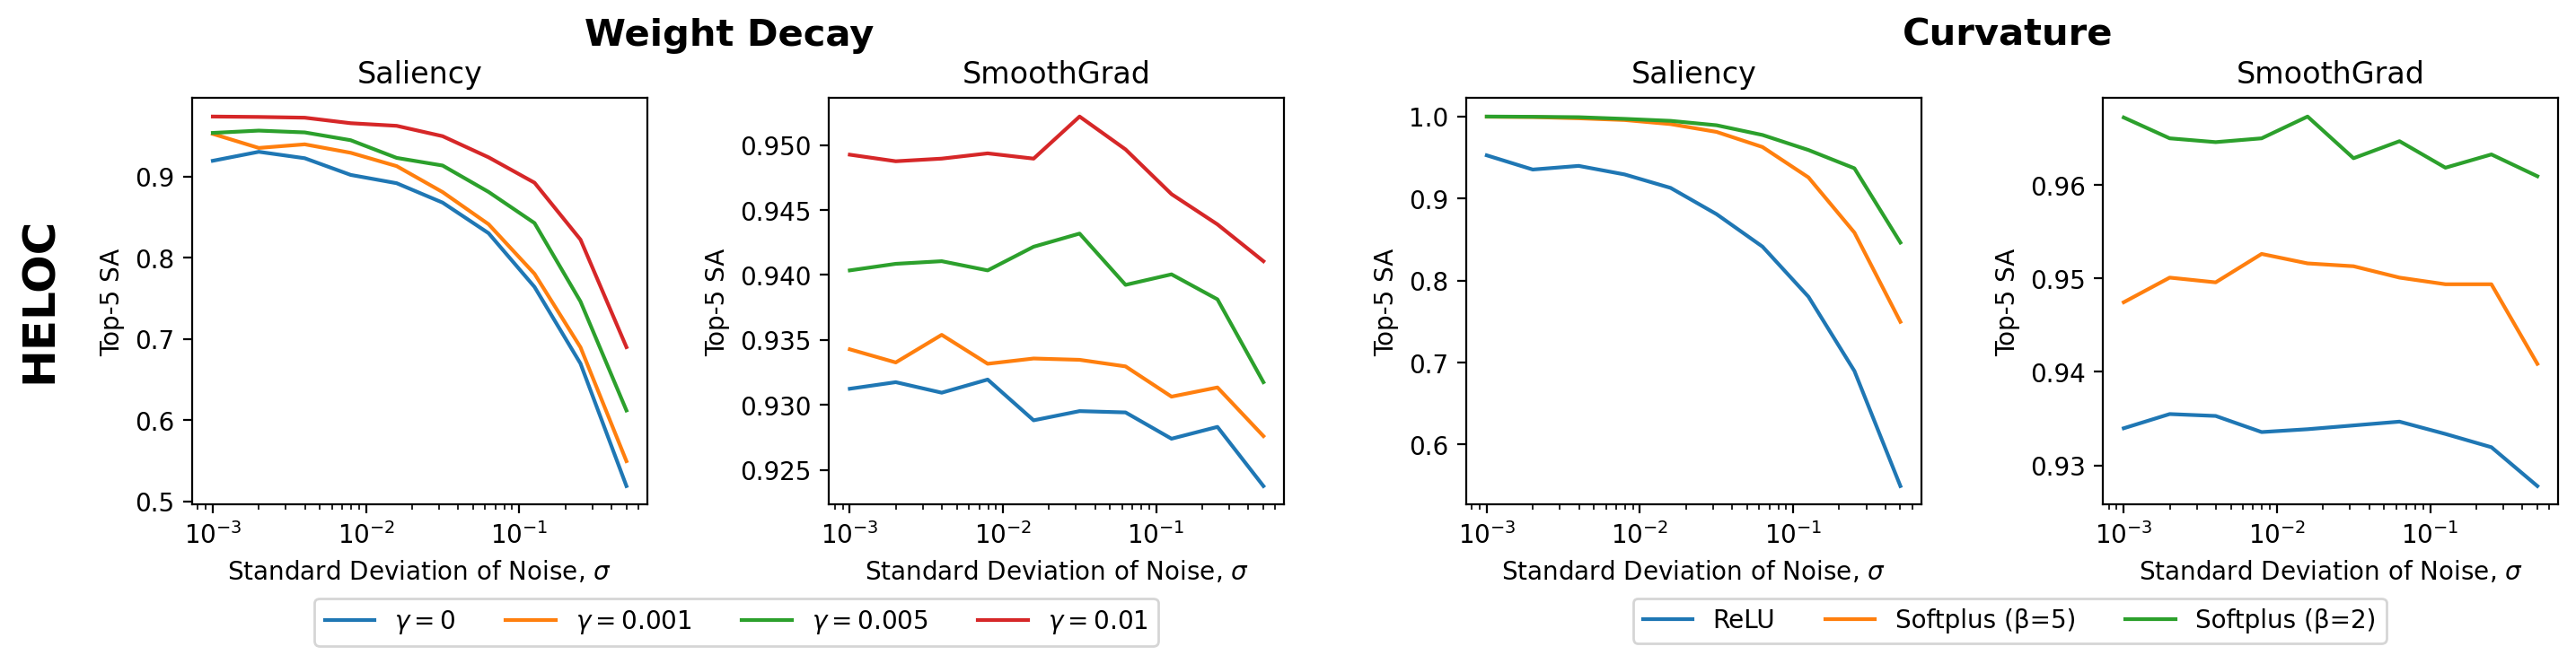

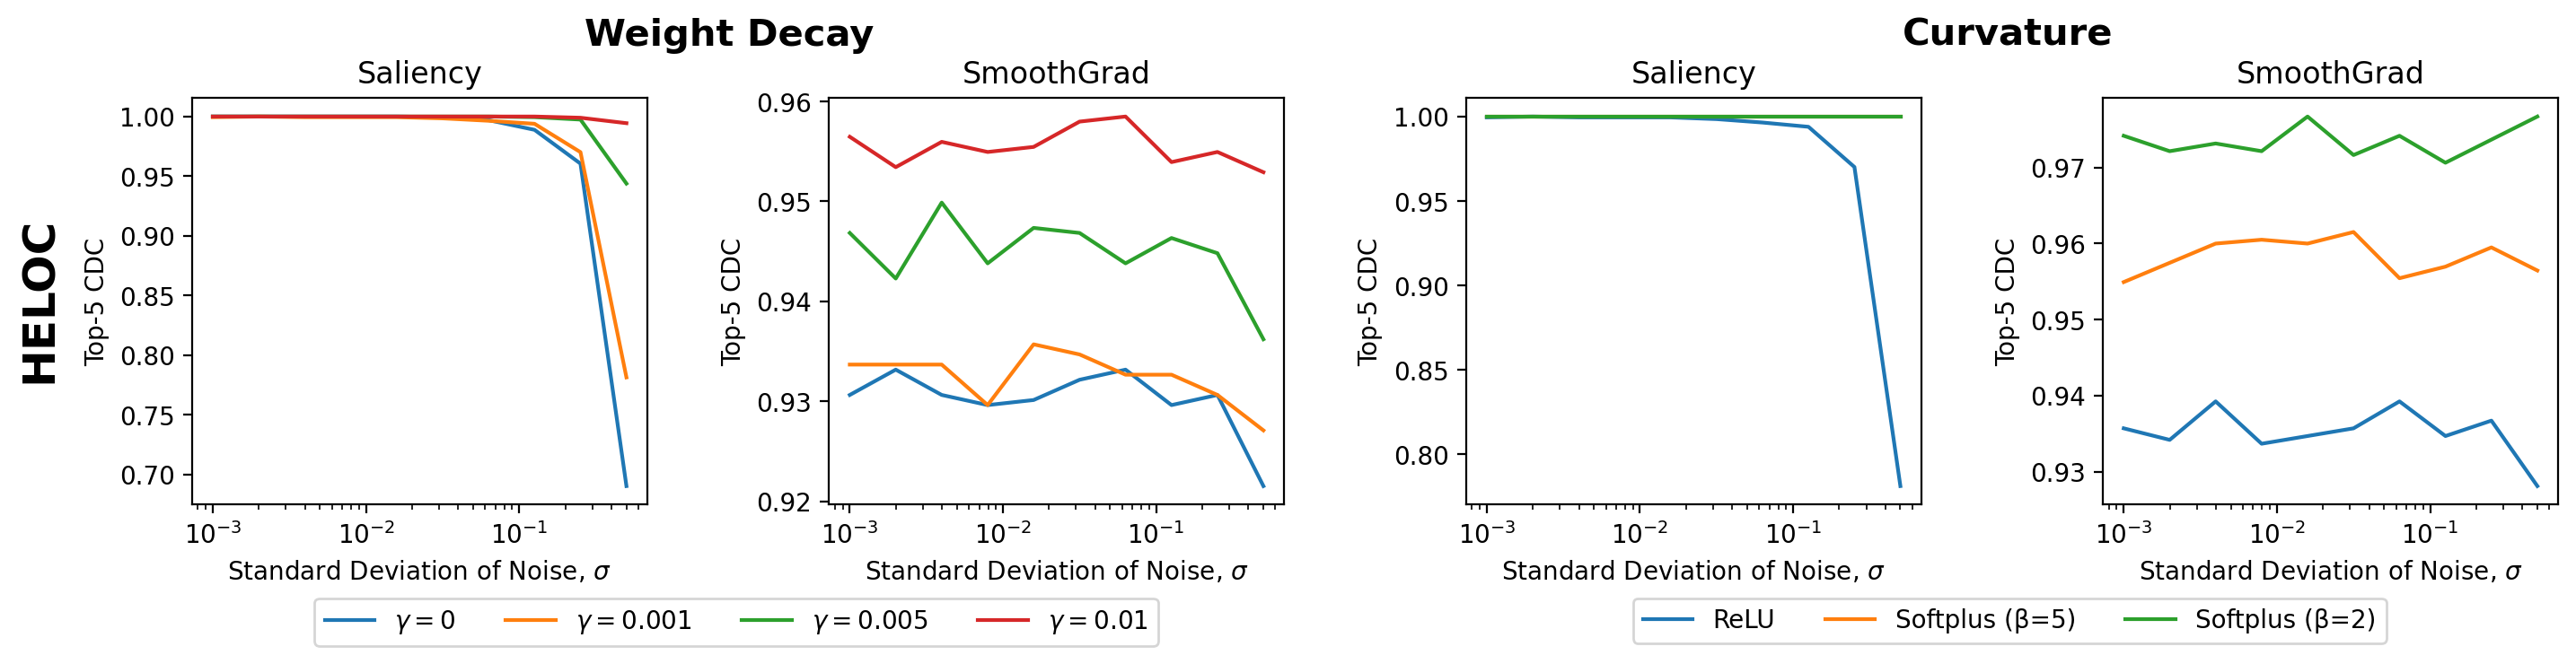

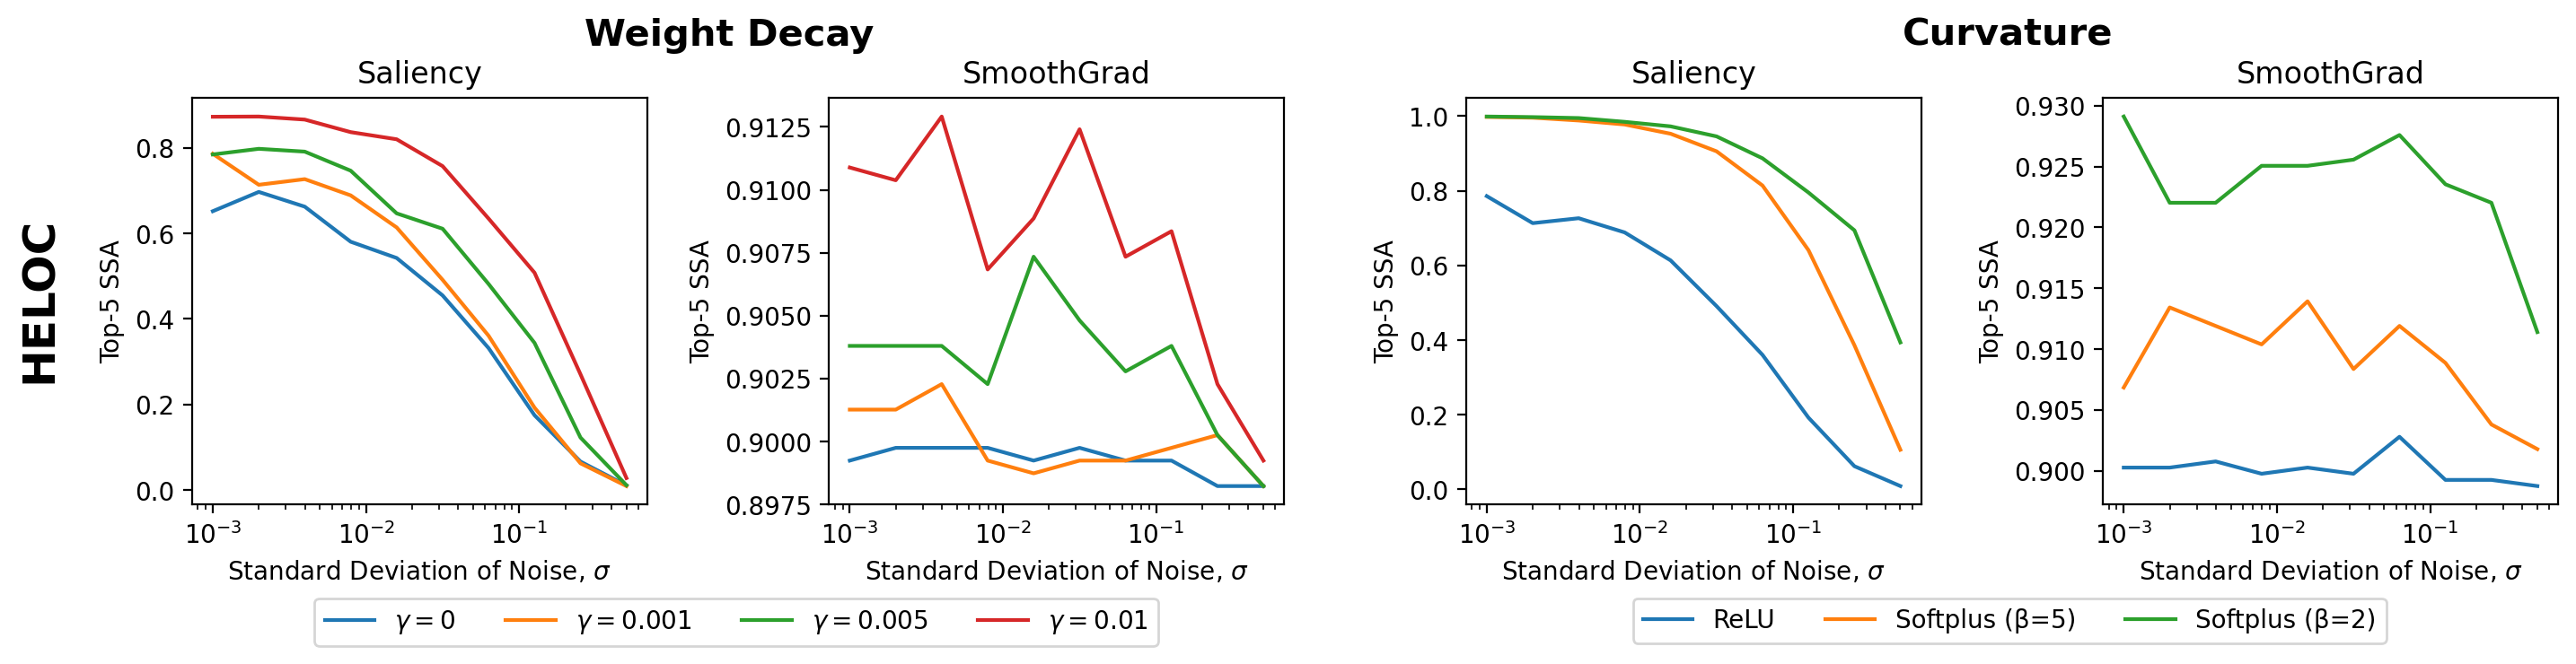

In [111]:
for met_name in met_names:
    top_k_plot(thresholds, exps, exp_names, met_name, labs,
               output_dir, dname=dname.upper(), dname_y=0.66, k=k)

### LIME/K.SHAP

In [117]:
exps = ['lime_grads', 'kernel_shap']
exp_names = ['LIME', 'K.SHAP']

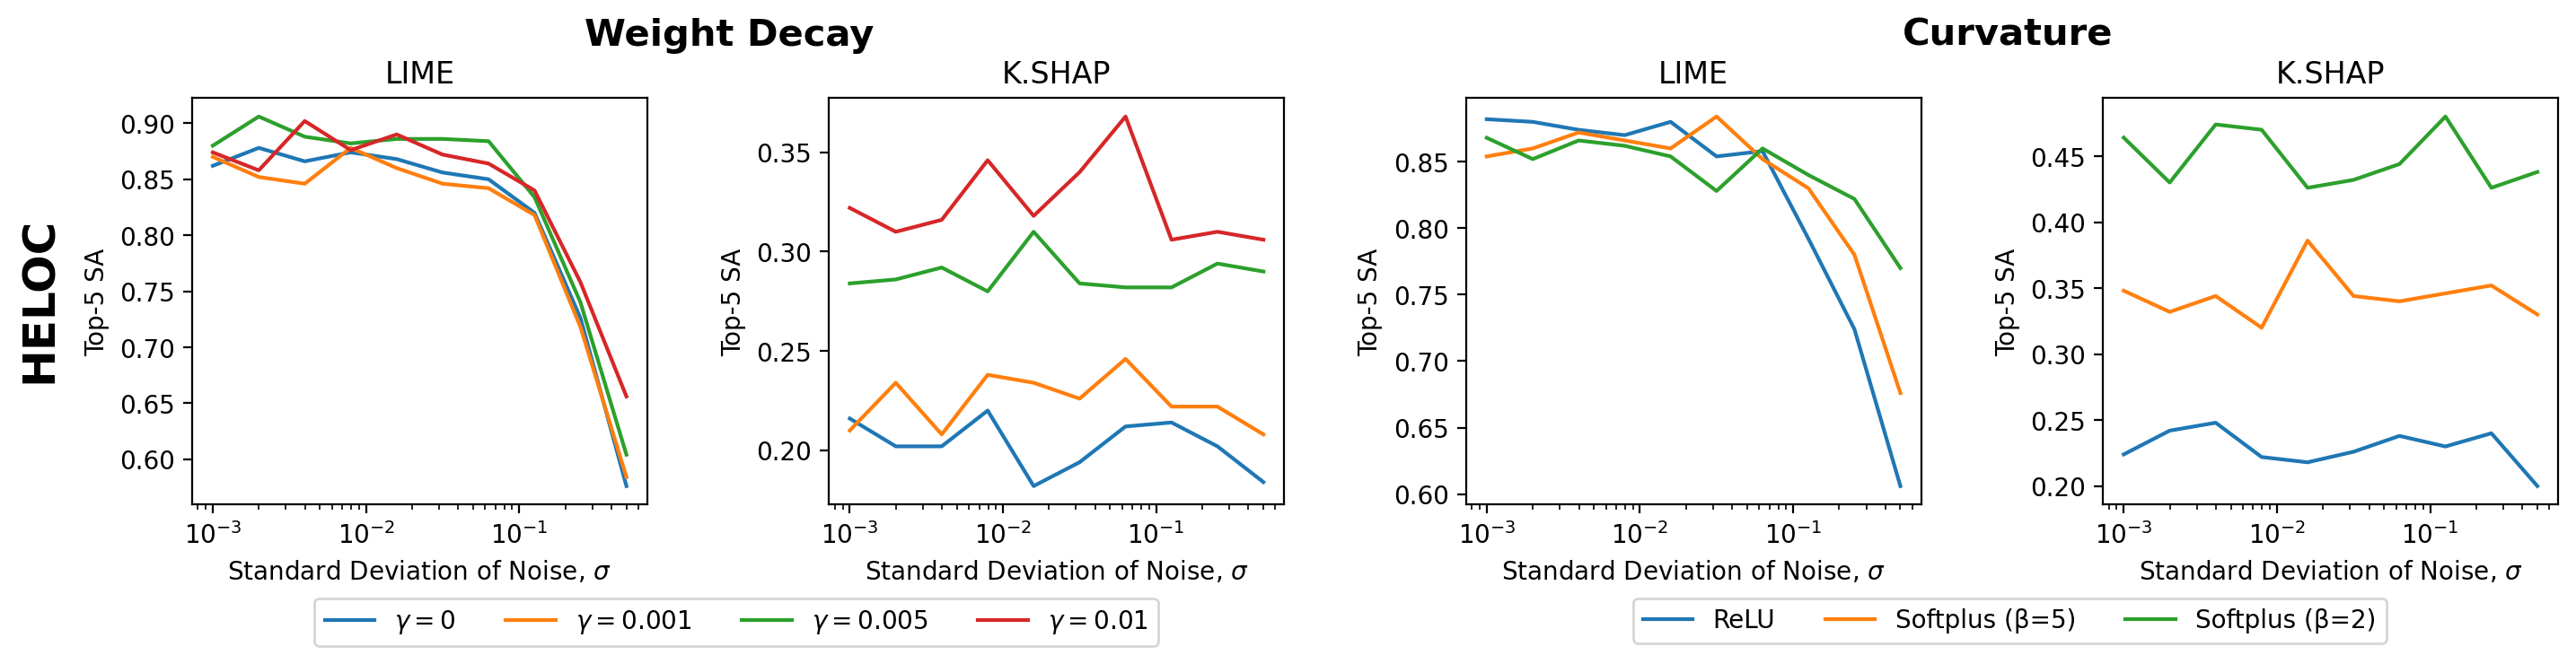

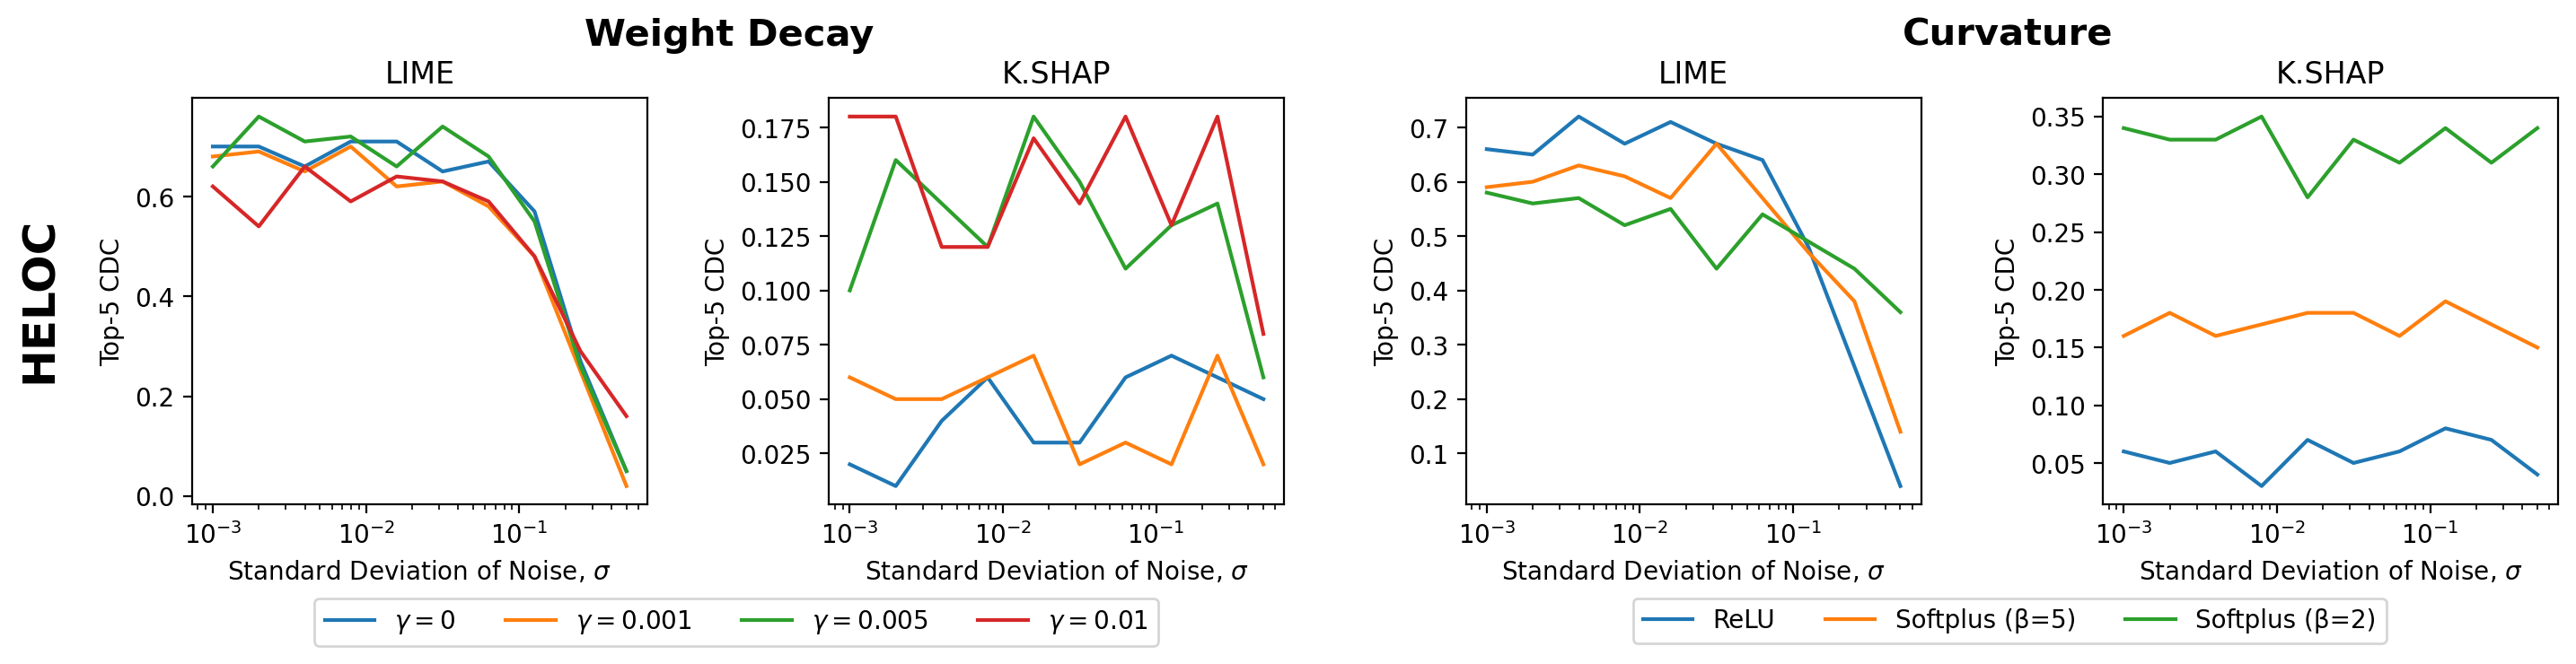

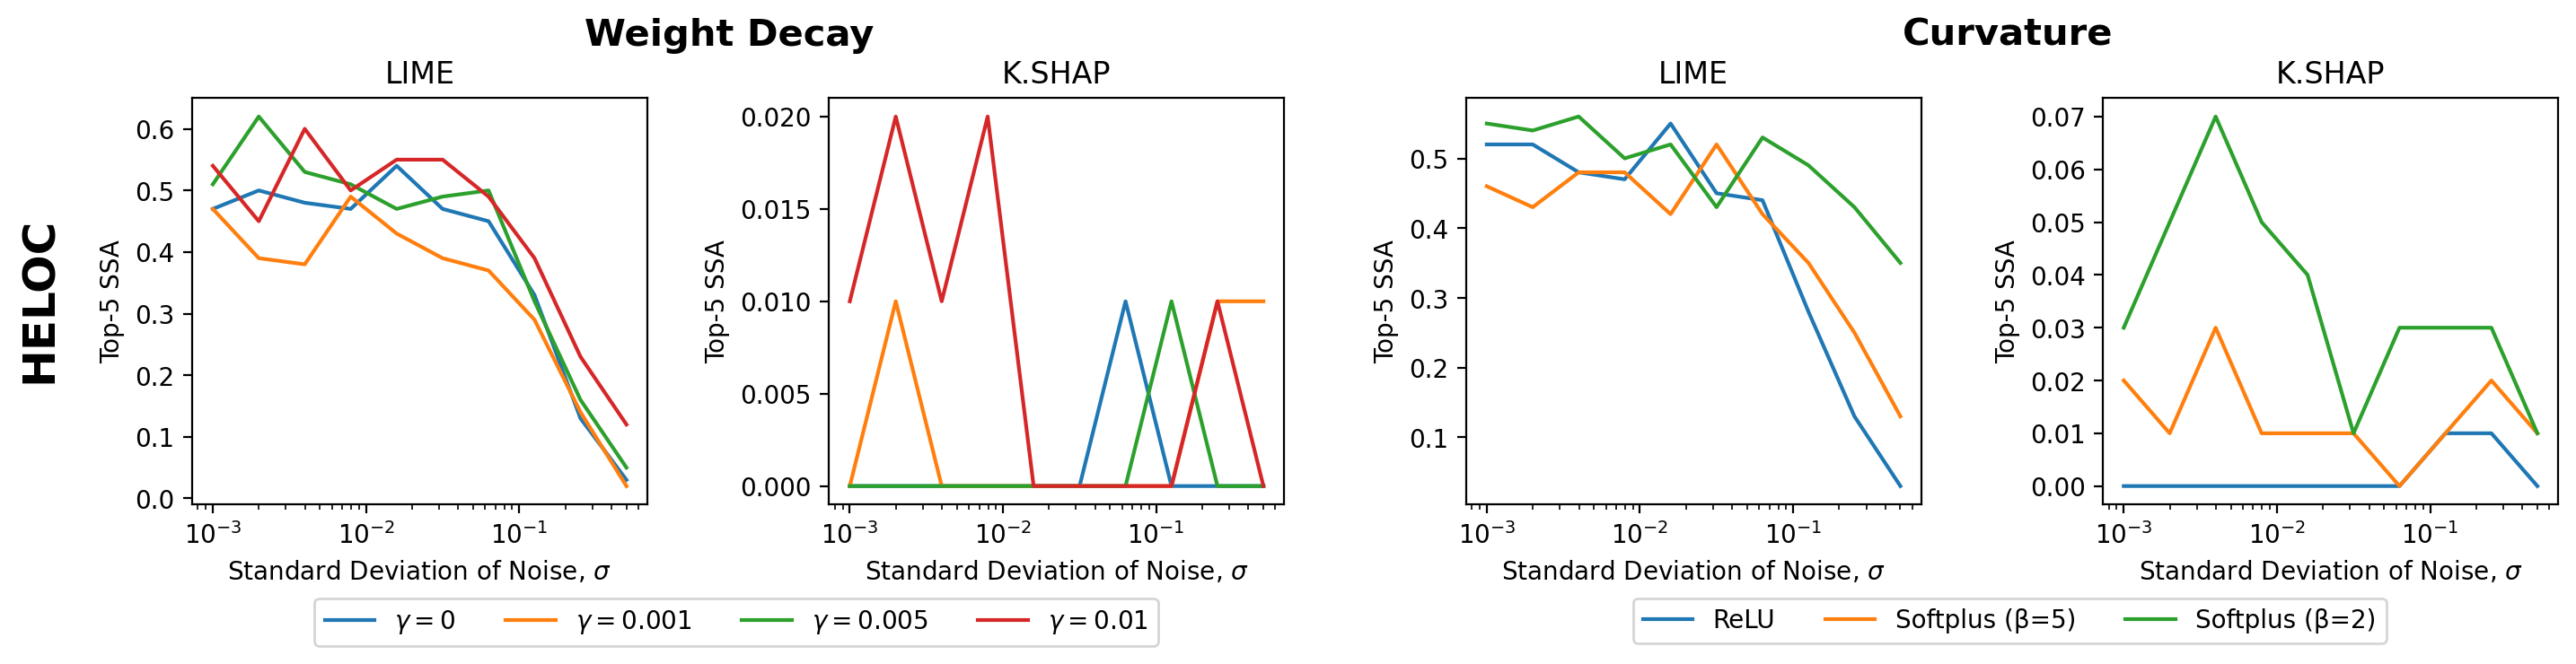

In [118]:
for met_name in met_names:
    top_k_plot(thresholds, exps, exp_names, met_name, labs,
               output_dir, dname=dname.upper(), dname_y=0.66, k=k)

# Plot Accuracy

In [18]:
from torch.utils.data import DataLoader
from neural_net import eval_model_grad
test_dataloader = DataLoader(orig_test, batch_size=args.batch_size, shuffle=False)

In [72]:
train_seeds = [3]

In [73]:
y = np.array(orig_test.labels).flatten()
X = torch.tensor(orig_test.data).to(torch.float)
y_tr = np.array(orig_train.labels).flatten()
X_tr = torch.tensor(orig_train.data).to(torch.float)

In [74]:
acts = ['relu']*4 + ['soft']*2
betas = ['']*4 + ['5', '2']
wds = [0, 0.001, 0.005, 0.01, 0.001, 0.001]
titles = [f'ReLU / $\\gamma={wd}$' for wd in wds[:4]] + ['SP / $\\beta=5$', 'SP / $\\beta=2$']
thresholds = np.logspace(-3, -0.3, 10)

In [76]:
noise_accs_te = np.zeros((len(acts), len(thresholds), len(train_seeds)))
noise_accs_tr = np.zeros((len(acts), len(thresholds), len(train_seeds)))
for a, act in enumerate(acts):
    wd = wds[a]
    b = betas[a]
    for i, threshold in enumerate(thresholds):
        for t, train_seed in enumerate(train_seeds):
            base = torch.load(output_dir+f'/model_thresh_idx{i}_{act+b}_wd{wd}_train_seed{train_seed}.npy')
            preds = np.array(base(X).argmax(axis=1))
            noise_accs_te[a,i,t] = np.mean(preds==y)*100
            preds_tr = np.array(base(X_tr).argmax(axis=1))
            noise_accs_tr[a,i,t] = np.mean(preds_tr==y_tr)*100

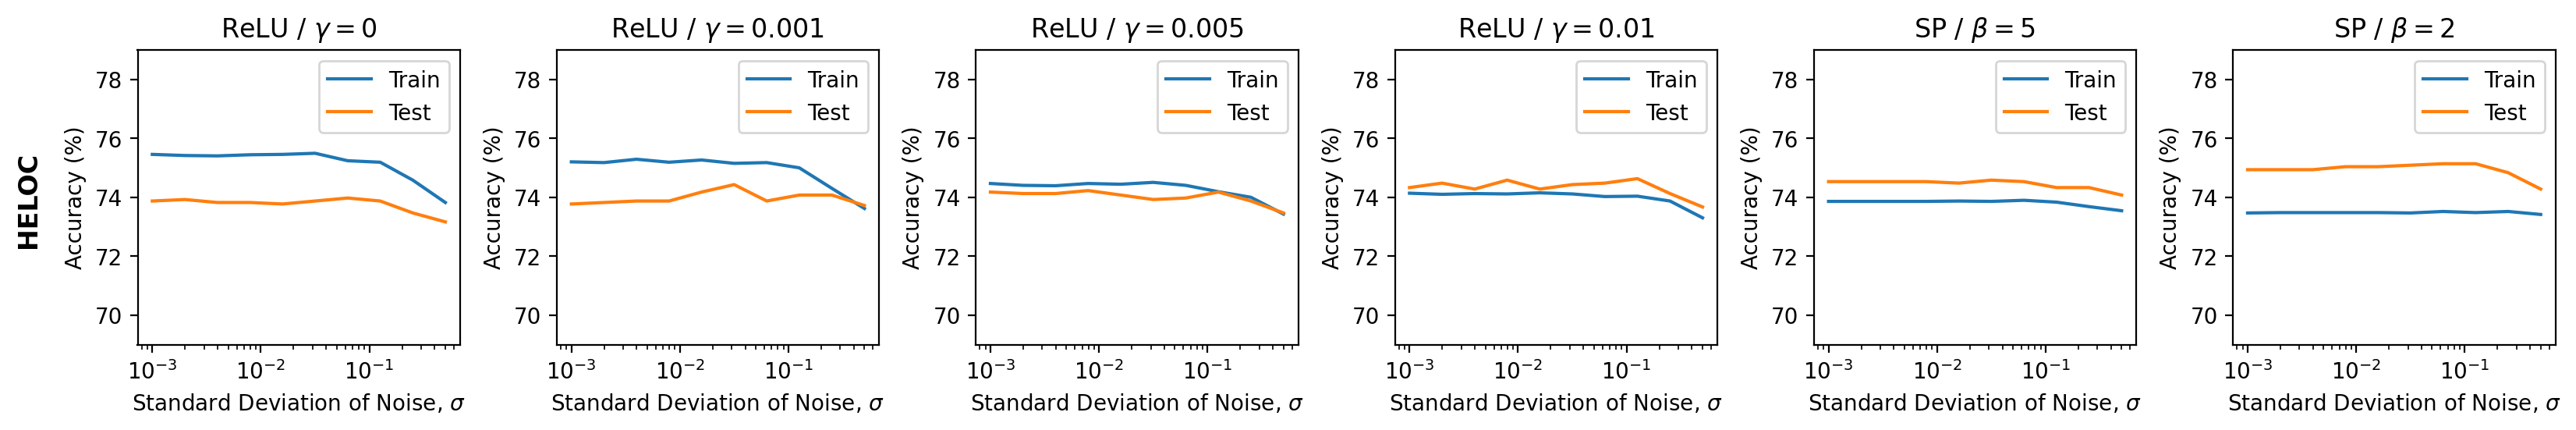

In [77]:
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(20,2.5), dpi=200)
plt.subplots_adjust(wspace=0.3)
for a, act in enumerate(acts):
    # Train
    q = np.quantile(noise_accs_tr[a], axis=1, q=[0.25, 0.5, 0.75])
    ax[a].plot(thresholds, q[1], label='Train')
    ax[a].fill_between(thresholds, q[0], q[2], alpha=0.4)
    # Test
    q = np.quantile(noise_accs_te[a], axis=1, q=[0.25, 0.5, 0.75])
    ax[a].plot(thresholds, q[1], label='Test')
    ax[a].fill_between(thresholds, q[0], q[2], alpha=0.4)
    # Titles
    ax[a].set_title(titles[a])
    ax[a].set_xlabel('Standard Deviation of Noise, $\sigma$')
    ax[a].set_ylabel('Accuracy (%)')
    ax[a].set_ylim([69, 79])
    ax[a].set_xscale('log')
    ax[a].legend()
plt.suptitle('HELOC', fontweight='bold', rotation=90, x=0.09, y=0.62)
plt.show()